In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
#results_dir = "/content/drive/MyDrive/H/qmlData"
data_dir = "../../QMLExperiments/Feature_Models/"

In [2]:
#import tensorflow as tf
#from tensorflow import keras
import matplotlib.pyplot as plt
import os
#from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score

#os.environ["OMP_NUM_THREADS"] = "1"


In [3]:
#import os
#os.chdir('/content/drive/MyDrive/H')

In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
import seaborn as sns

def load_all_results(data_dir="qmlData"):
    all_results = {}

    #feature_models_dir = os.path.join(data_dir, "FeatureModels")
    feature_models_dir = data_dir

    dataset_folders = [d for d in os.listdir(feature_models_dir)
                      if os.path.isdir(os.path.join(feature_models_dir, d)) and d.endswith("_models")]

    for dataset_folder in dataset_folders:
        dataset = dataset_folder.replace("_models", "")

        dataset_path = os.path.join(feature_models_dir, dataset_folder)

        pkl_files = [f for f in os.listdir(dataset_path) if f.endswith(".pkl")]

        for pkl_file in pkl_files:
            model = pkl_file.split('_')[0]

            file_path = os.path.join(dataset_path, pkl_file)

            try:
                with open(file_path, 'rb') as f:
                    results = pickle.load(f)

                if dataset not in all_results:
                    all_results[dataset] = {}

                all_results[dataset][model] = results
                print(f"Loaded: {model} model for {dataset} dataset")

            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    return all_results

def compare_accuracy_bar_plots(all_results, data_dir="qmlData", compare_pairs=[("svm", "qsvm"), ("knn", "qknn")]):
    for model1, model2 in compare_pairs:
        datasets = []
        acc1 = []
        acc2 = []

        for dataset, models in all_results.items():
            if model1 in models and model2 in models:
                datasets.append(dataset)
                acc1.append(models[model1]['accuracy'])
                acc2.append(models[model2]['accuracy'])

        plt.figure(figsize=(12, 6))

        bar_width = 0.35
        index = np.arange(len(datasets))

        color1 = 'steelblue'  # Classical methods
        color2 = 'lightblue'  # Quantum methods

        plt.bar(index, acc1, bar_width, label=model1.upper(), color=color1)
        plt.bar(index + bar_width, acc2, bar_width, label=model2.upper(), color=color2)

        plt.xlabel('Dataset', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title(f'Accuracy Comparison: {model1.upper()} vs {model2.upper()}', fontsize=14)
        plt.xticks(index + bar_width/2, datasets, rotation=45, ha='right')
        plt.legend()

        for i, v in enumerate(acc1):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

        for i, v in enumerate(acc2):
            plt.text(i + bar_width, v + 0.01, f'{v:.3f}', ha='center')

        plt.ylim(0, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, f'accuracy_comparison_{model1}_vs_{model2}.png'), dpi=300, bbox_inches='tight')
        plt.show()

def calculate_auc_values(all_results):
    auc_values = {}

    for dataset, models in all_results.items():
        auc_values[dataset] = {}

        for model_name, results in models.items():
            y_test = results['y_test']
            y_prob = results['y_prob']

            n_classes = len(np.unique(y_test))

            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)

            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

            mean_tpr /= n_classes
            macro_auc = auc(all_fpr, mean_tpr)

            auc_values[dataset][model_name] = macro_auc

    return auc_values

def compare_auc_bar_plots(all_results, data_dir="qmlData", compare_pairs=[("svm", "qsvm"), ("knn", "qknn")]):
    auc_values = calculate_auc_values(all_results)

    for model1, model2 in compare_pairs:
        datasets = []
        dataset_labels = ['APTOS-2019 (Diabetic Retinopathy)', 'MESSIDOR (Diabetic Retinopathy)', 'IDRID (Diabetic Retinopathy)', 'PAPILA (Glaucoma)', 'Glaucoma Fundus (Glaucoma)', 'G1020 (Glaucoma)']
        auc1 = []
        auc2 = []

        for dataset, models in auc_values.items():
            if model1 in models and model2 in models:
                datasets.append(dataset)
                auc1.append(models[model1])
                auc2.append(models[model2])

        plt.figure(figsize=(12, 6))

        bar_width = 0.35
        index = np.arange(len(datasets))

        color1 = 'steelblue'  # Classical methods
        color2 = 'lightblue'  # Quantum methods

        plt.bar(index, auc1, bar_width, label=model1.upper(), color=color1, alpha=0.7)
        plt.bar(index + bar_width, auc2, bar_width, label=model2.upper(), color=color2, alpha=0.7)

        plt.xlabel('Dataset', fontsize=12)
        plt.ylabel('AUC', fontsize=12)
        plt.title(f'AUC Comparison: {model1.upper()} vs {model2.upper()}', fontsize=14)
        plt.xticks(index + bar_width/2, dataset_labels, rotation=45, ha='right')
        plt.legend()

        for i, v in enumerate(auc1):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

        for i, v in enumerate(auc2):
            plt.text(i + bar_width, v + 0.01, f'{v:.3f}', ha='center')

        plt.ylim(0, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, f'auroc_comparison_{model1}_vs_{model2}.png'), dpi=300, bbox_inches='tight')
        plt.show()

        mean_auc1 = np.mean(auc1)
        mean_auc2 = np.mean(auc2)

        plt.figure(figsize=(6, 8))
        plt.bar(0, mean_auc1, bar_width*2, label=model1.upper(), color=color1, alpha = 0.7)
        plt.bar(1, mean_auc2, bar_width*2, label=model2.upper(), color=color2, alpha = 0.7)

        plt.ylabel('Mean AUC', fontsize=12)
        plt.title(f'Mean AUC Across Datasets: {model1.upper()} vs {model2.upper()}', fontsize=14)
        plt.xticks([0, 1], [model1.upper(), model2.upper()])
        plt.legend()

        plt.text(0, mean_auc1 + 0.01, f'{mean_auc1:.3f}', ha='center')
        plt.text(1, mean_auc2 + 0.01, f'{mean_auc2:.3f}', ha='center')

        plt.ylim(0, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, f'mean_auc_comparison_{model1}_vs_{model2}.png'), dpi=300, bbox_inches='tight')
        plt.show()


def plot_roc_curves(all_results, data_dir="qmlData"):
    plt.rcParams.update({'font.size': 16})

    for dataset, models in all_results.items():
        plt.figure(figsize=(8, 7))

        first_model = next(iter(models.values()))
        class_names = first_model['class_names']
        n_classes = len(class_names)

        colors = cycle(['blue', 'green', 'orange', 'red'])
        line_styles = cycle(['-', '--', ':', '-.'])

        for model_name, results in models.items():
            y_test = results['y_test']
            y_prob = results['y_prob']

            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes

            macro_auc = auc(all_fpr, mean_tpr)

            color = next(colors)
            linestyle = next(line_styles)
            plt.plot(
                all_fpr, mean_tpr,
                label=f'{model_name.upper()} (AUC = {macro_auc:.2f})',
                color=color, linestyle=linestyle, linewidth=2
            )

        plt.plot([0, 1], [0, 1], 'k--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate', fontsize=18)
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(f'ROC Curves for {dataset} Dataset', fontsize=22)
        plt.legend(loc="lower right", fontsize=14)

        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, f'a_roc_curves_{dataset}.pdf'), format='pdf', bbox_inches='tight')
        plt.show()

        for model_name, results in models.items():
            plt.figure(figsize=(8, 7))

            y_test = results['y_test']
            y_prob = results['y_prob']

            for i, class_name in enumerate(class_names):
                fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
                roc_auc = auc(fpr, tpr)

                plt.plot(
                    fpr, tpr,
                    label=f'Class {class_name} (AUC = {roc_auc:.2f})',
                    linewidth=2
                )

            fpr = dict()
            tpr = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])

            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes

            macro_auc = auc(all_fpr, mean_tpr)

            plt.plot(
                all_fpr, mean_tpr,
                label=f'Macro-average (AUC = {macro_auc:.2f})',
                color='navy', linestyle=':', linewidth=4
            )

            plt.plot([0, 1], [0, 1], 'k--')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('False Positive Rate', fontsize=18)
            plt.ylabel('True Positive Rate', fontsize=18)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.title(f'ROC Curves: {model_name.upper()} on {dataset}', fontsize=22)
            plt.legend(loc="lower right", fontsize=14)

            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, f'a_roc_curves_{model_name}_{dataset}.pdf'), format='pdf', bbox_inches='tight')
            plt.show()


def create_performance_tables(all_results, data_dir="qmlData"):
    overall_metrics = []

    for dataset, models in all_results.items():
        for model_name, results in models.items():
            overall_metrics.append({
                'Dataset': dataset,
                'Model': model_name.upper(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1 Score': results['f1'],
                'Is Quantum': 'Yes' if results['is_quantum'] else 'No'
            })

    metrics_df = pd.DataFrame(overall_metrics)

    metrics_df = metrics_df.sort_values(['Dataset', 'Model'])

    print("\n===== OVERALL PERFORMANCE METRICS =====")
    print(metrics_df.to_string(index=False))

    metrics_df.to_csv(os.path.join(data_dir, 'performance_metrics.csv'), index=False)


Loaded: svm model for MESSIDOR dataset
Loaded: qknn model for MESSIDOR dataset
Loaded: qsvm model for MESSIDOR dataset
Loaded: knn model for MESSIDOR dataset
Loaded: qknn model for IDRID dataset
Loaded: knn model for IDRID dataset
Loaded: qsvm model for IDRID dataset
Loaded: svm model for IDRID dataset
Loaded: qsvm model for APTOS dataset
Loaded: qknn model for APTOS dataset
Loaded: knn model for APTOS dataset
Loaded: svm model for APTOS dataset
Loaded: qknn model for PAPILA dataset
Loaded: qsvm model for PAPILA dataset
Loaded: knn model for PAPILA dataset
Loaded: svm model for PAPILA dataset
Loaded: qsvm model for G1020 dataset
Loaded: svm model for G1020 dataset
Loaded: knn model for G1020 dataset
Loaded: qknn model for G1020 dataset
Loaded: svm model for GlaucomaFundus dataset
Loaded: qknn model for GlaucomaFundus dataset
Loaded: qsvm model for GlaucomaFundus dataset
Loaded: knn model for GlaucomaFundus dataset


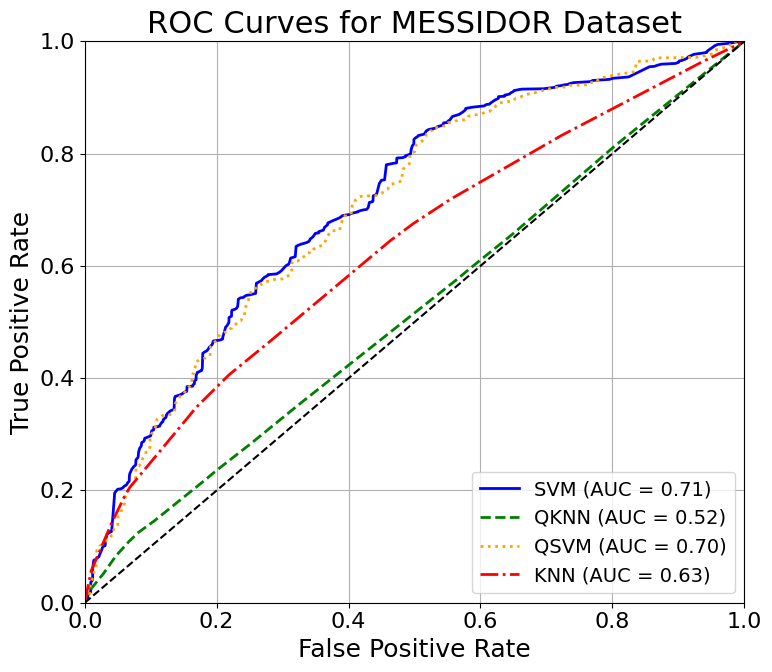

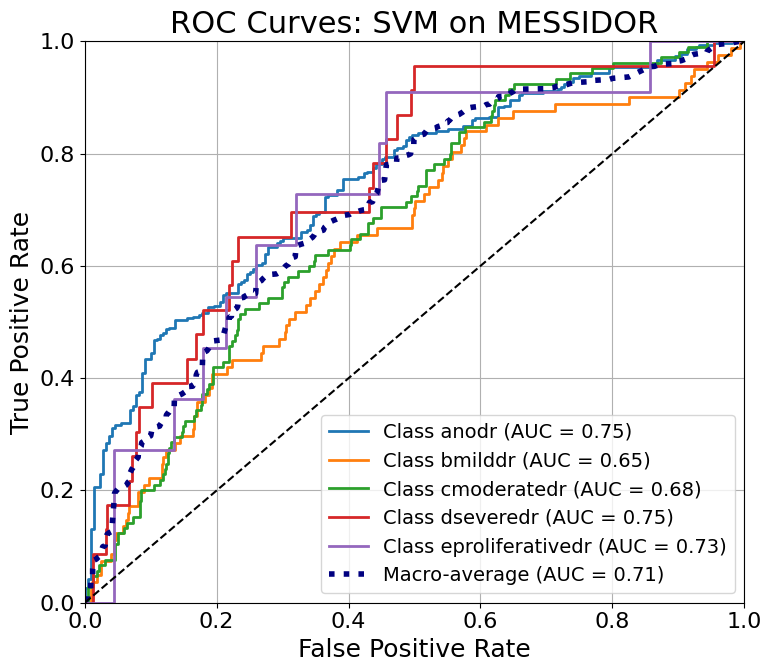

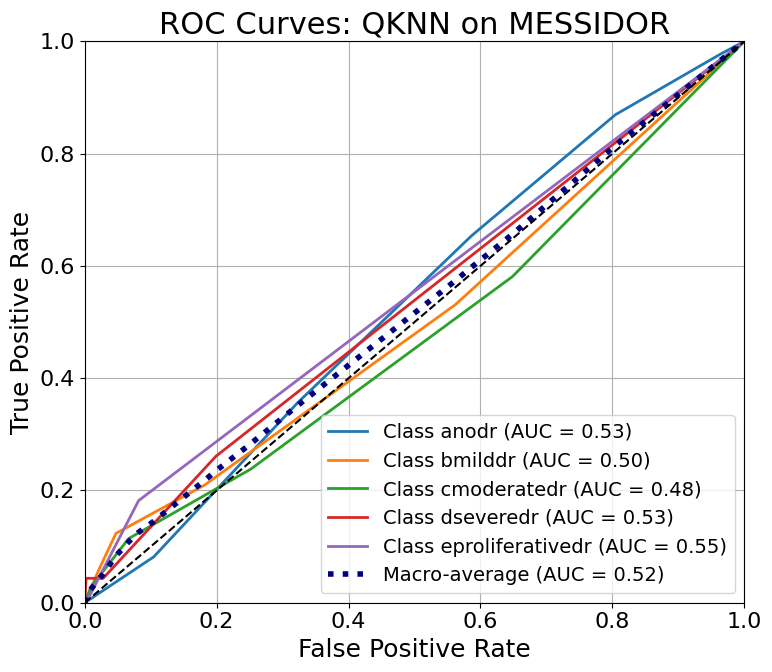

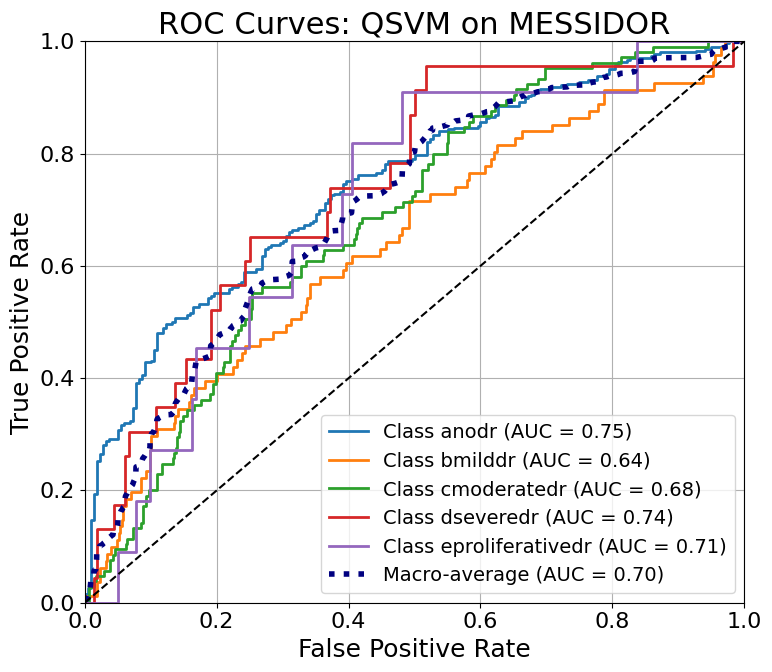

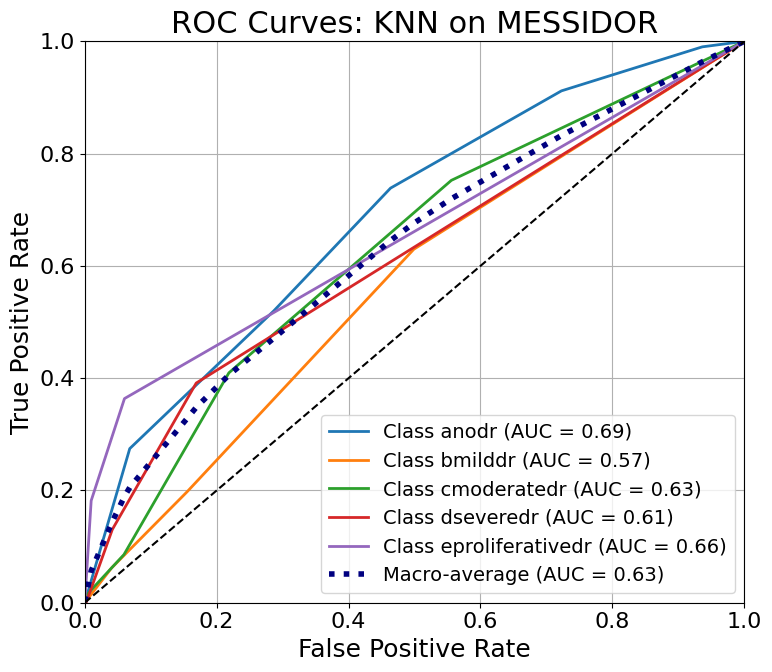

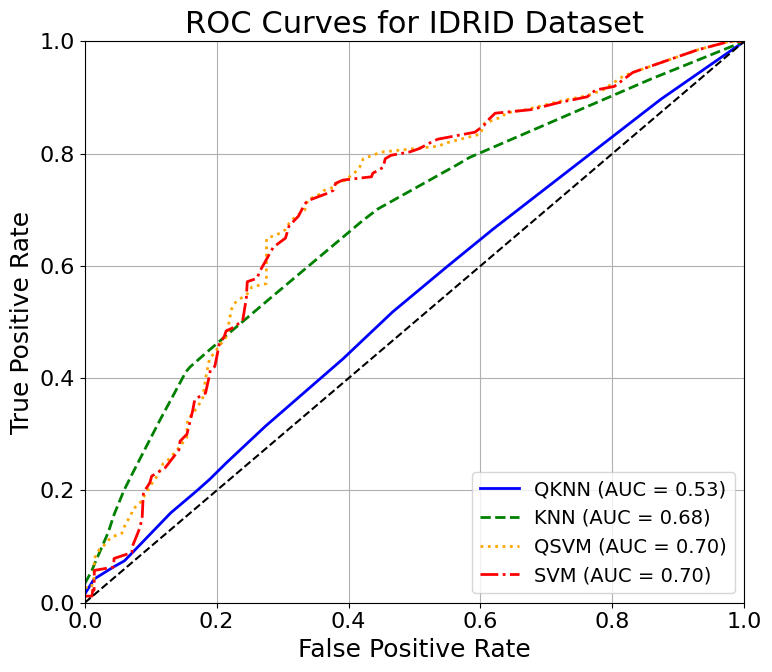

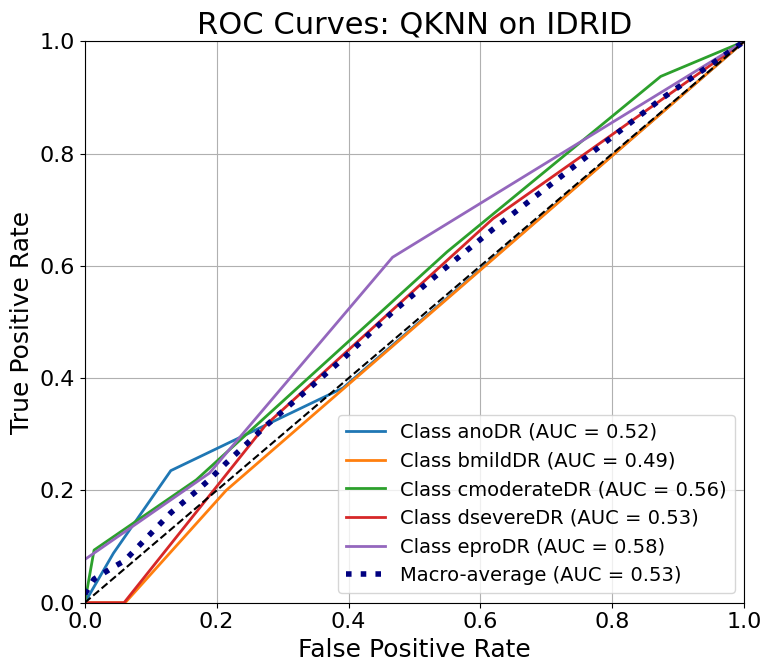

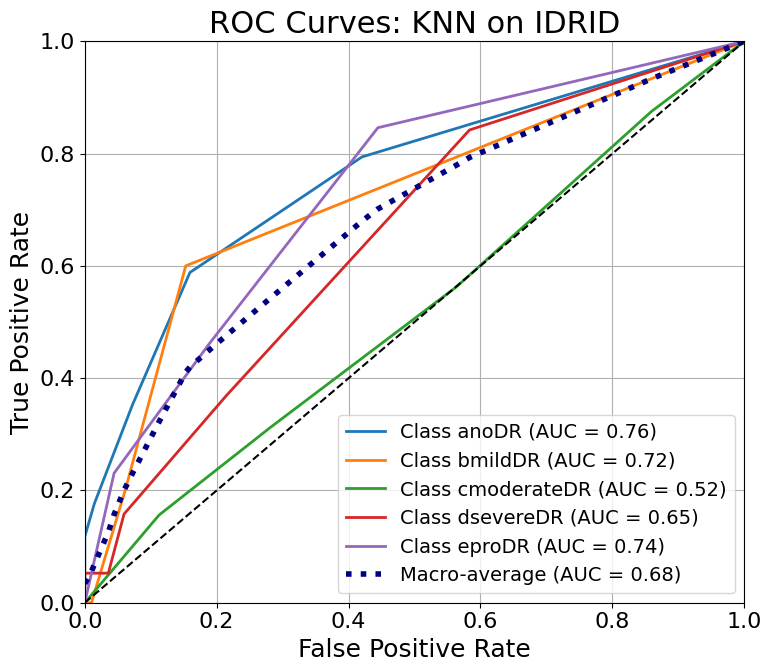

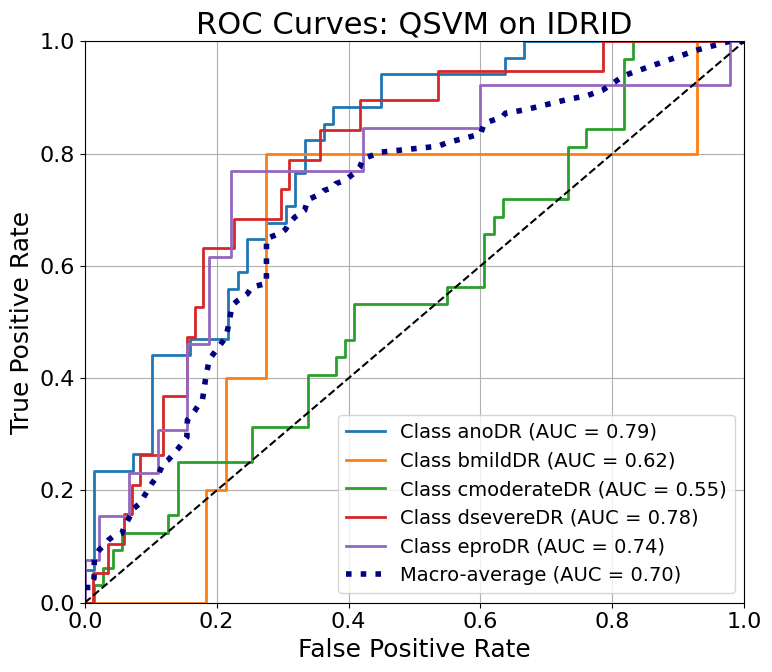

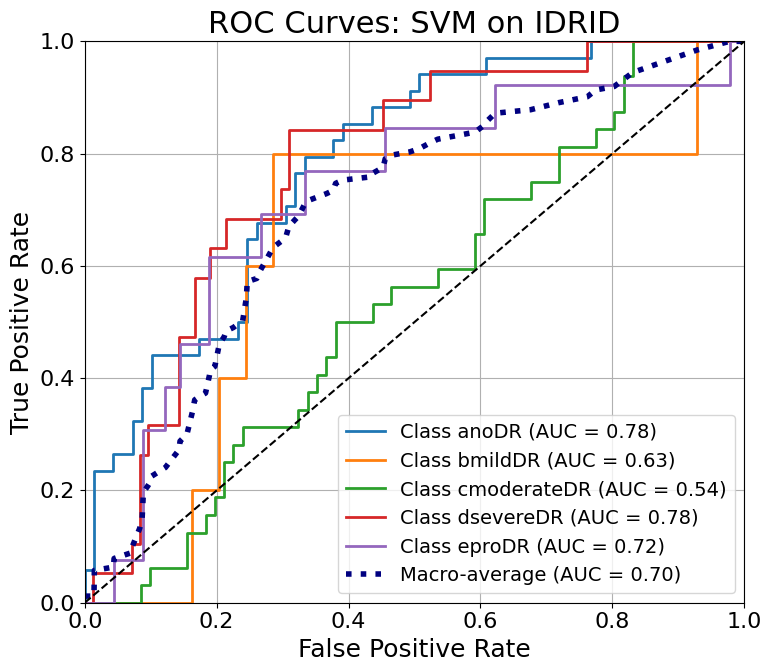

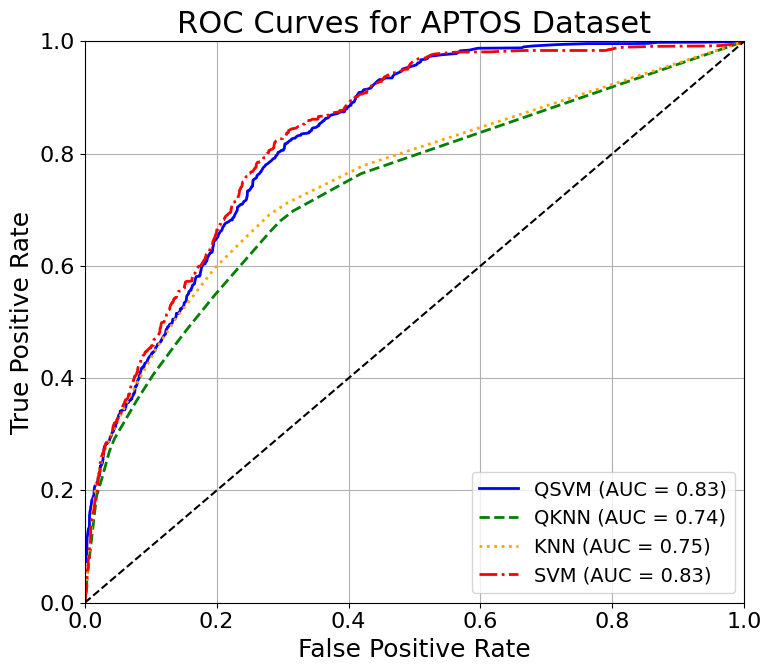

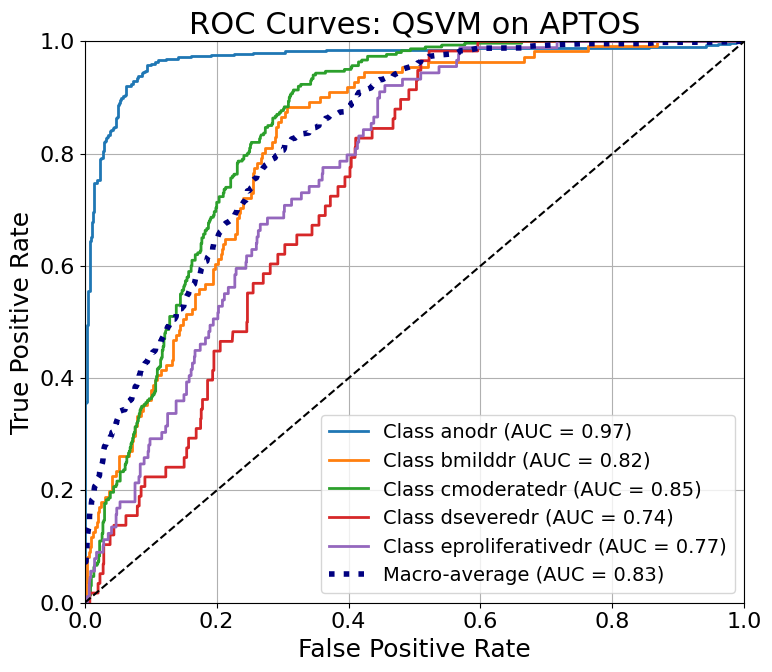

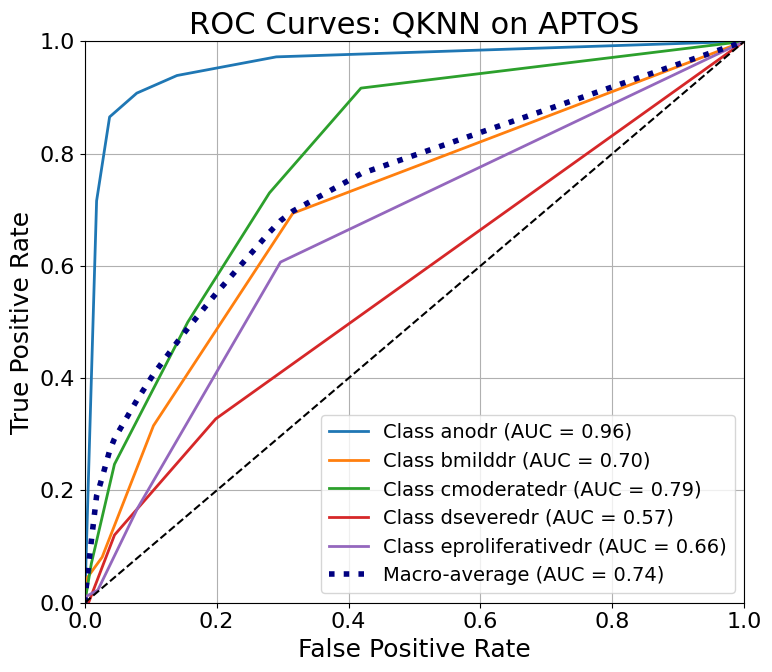

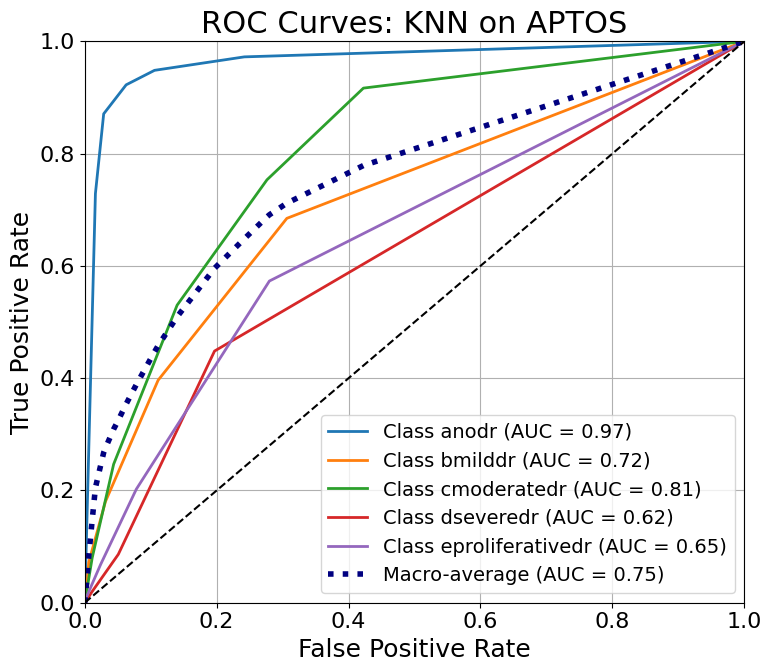

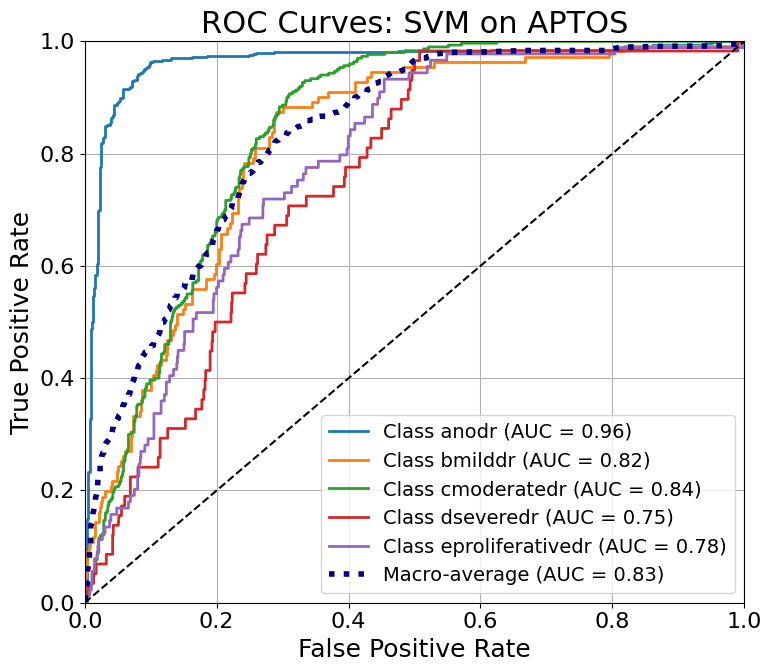

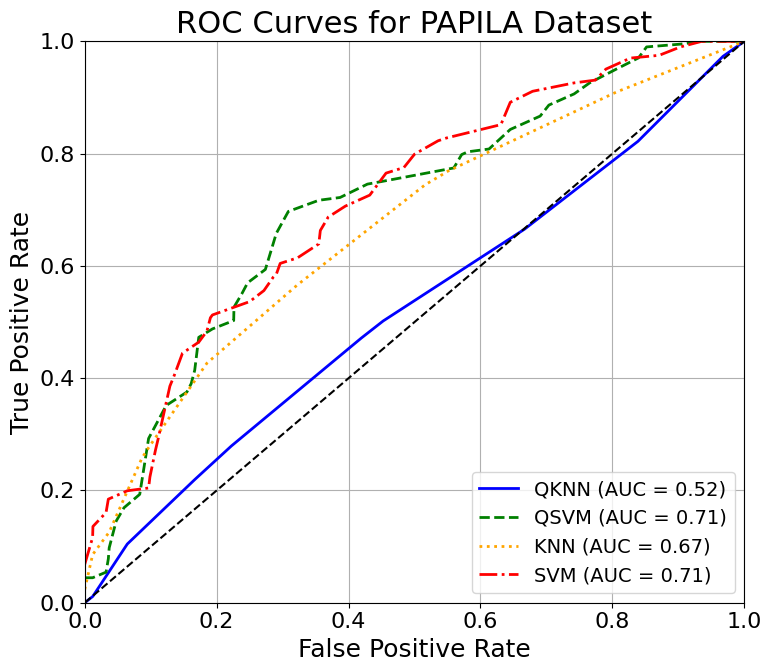

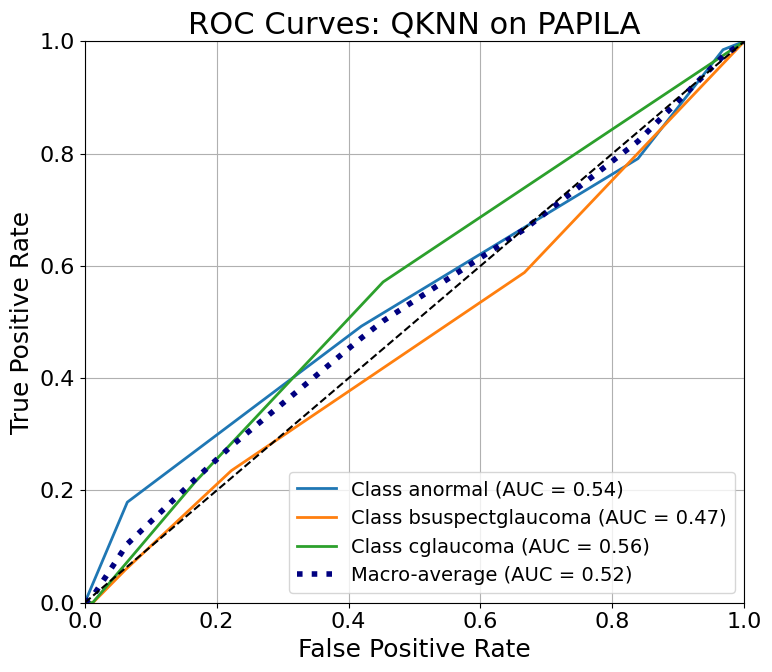

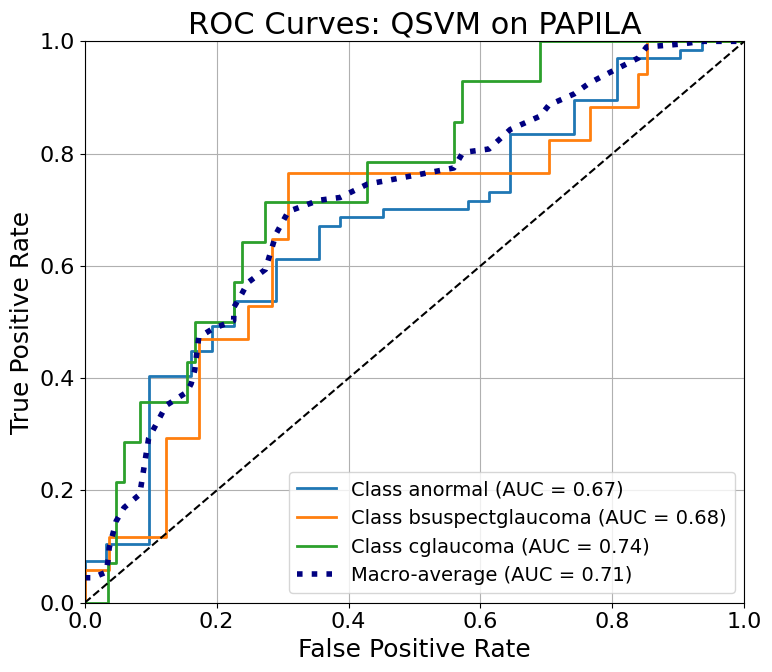

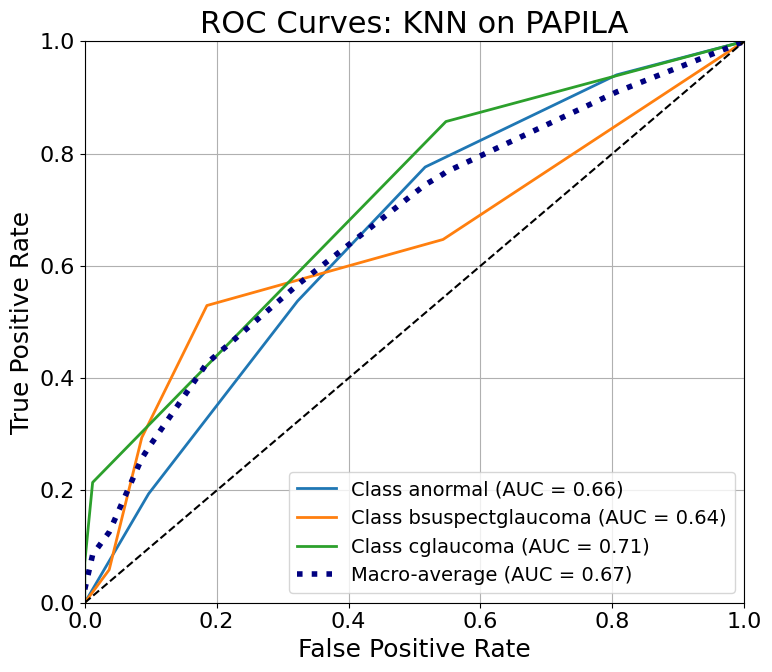

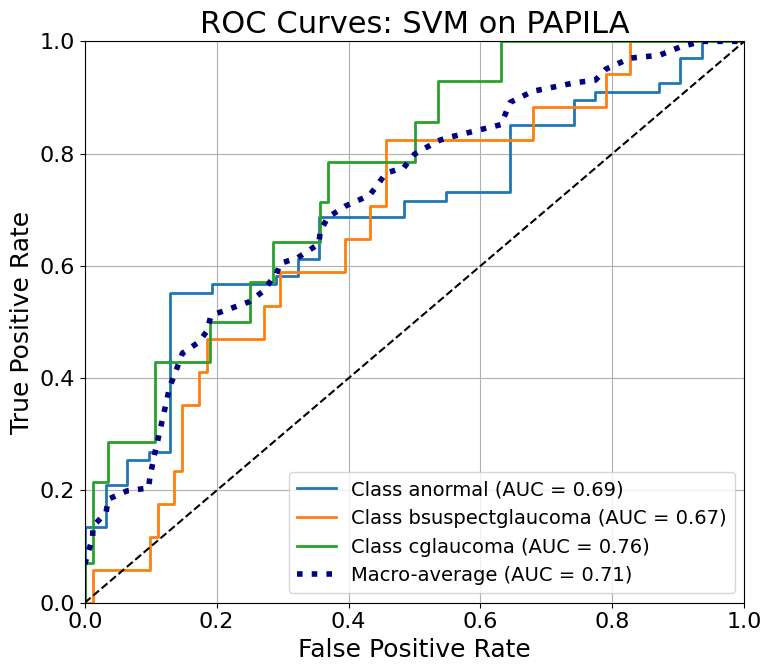

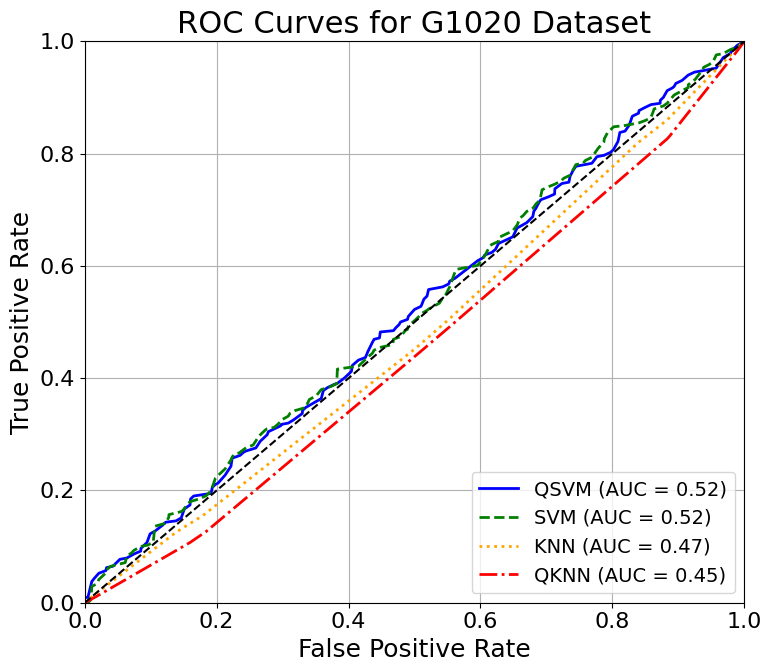

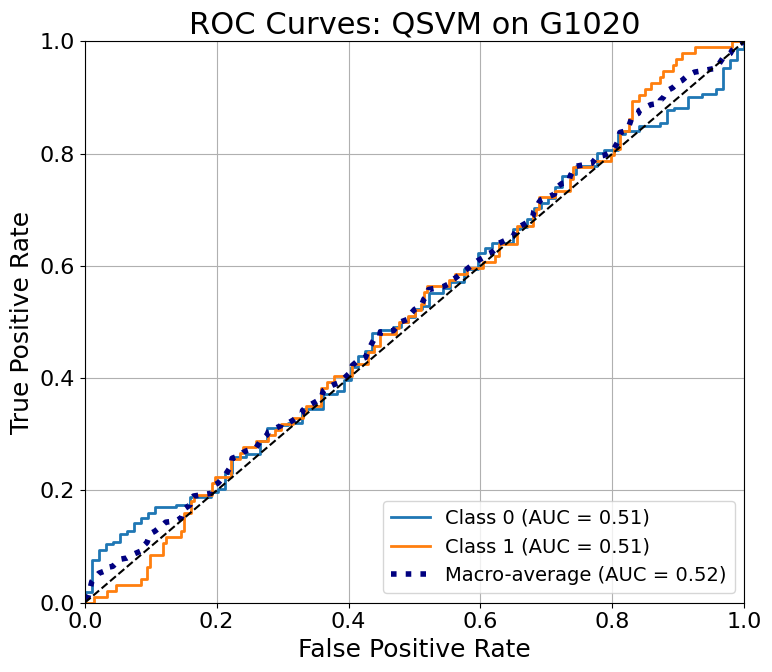

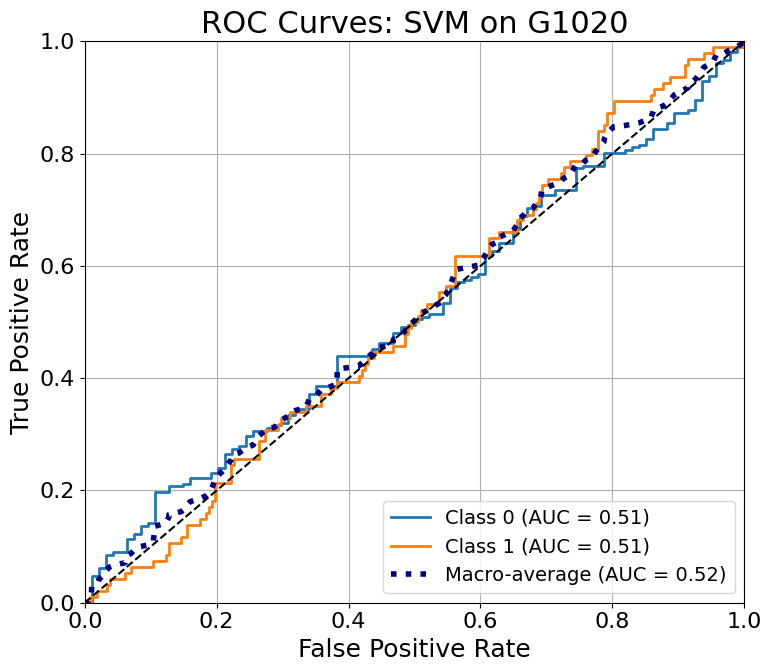

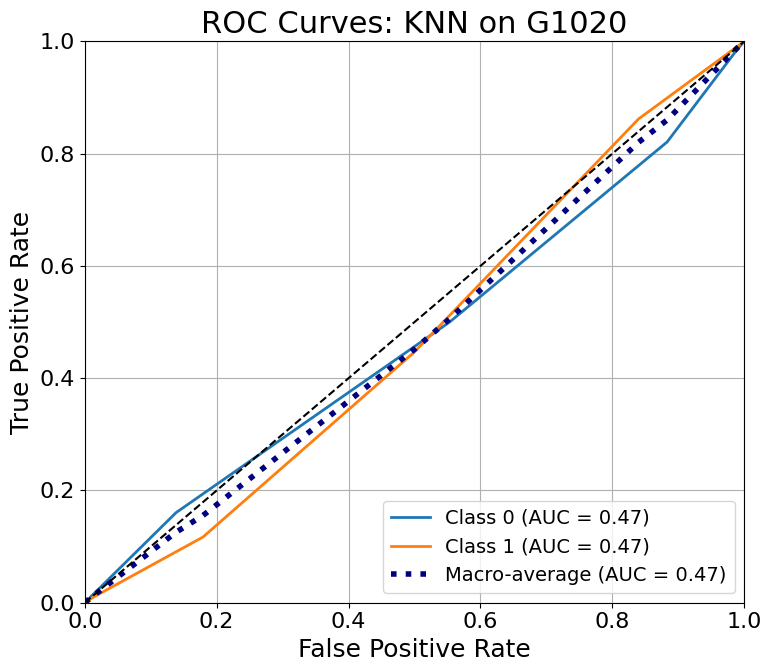

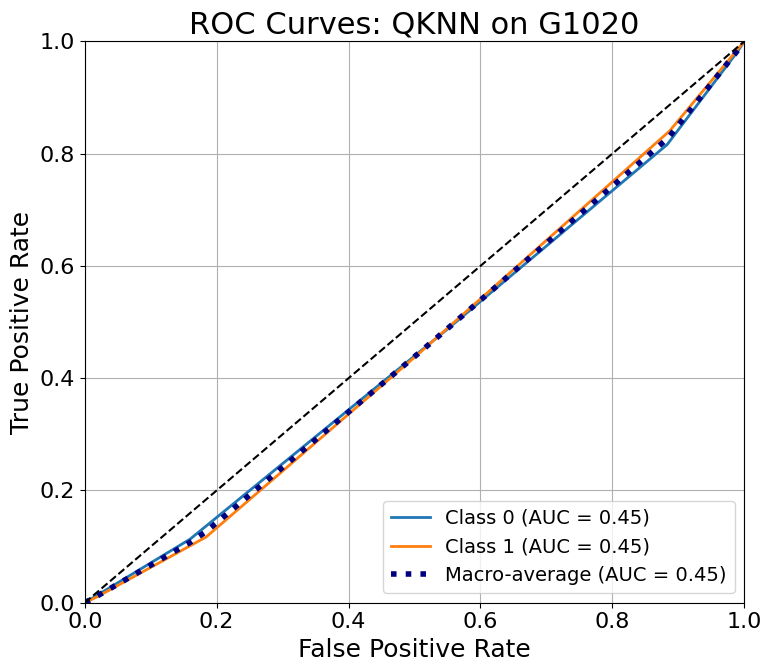

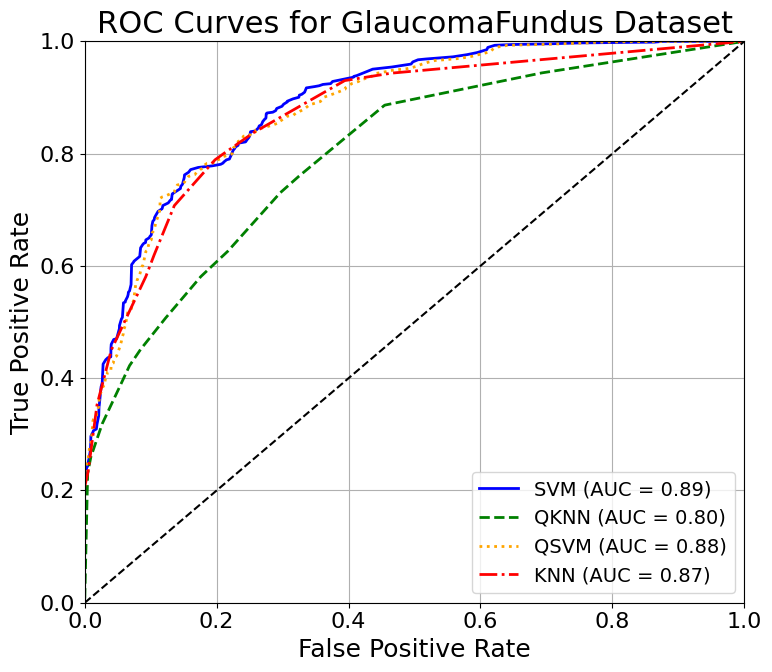

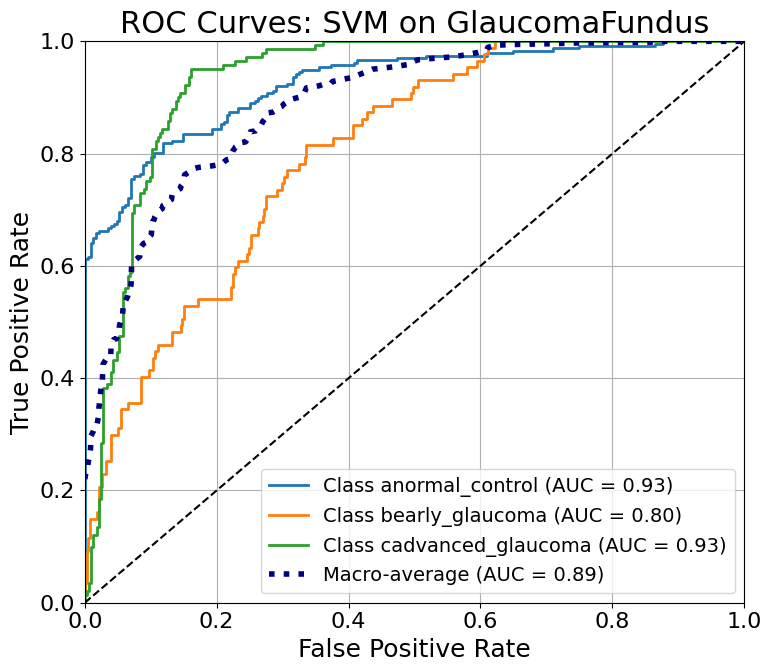

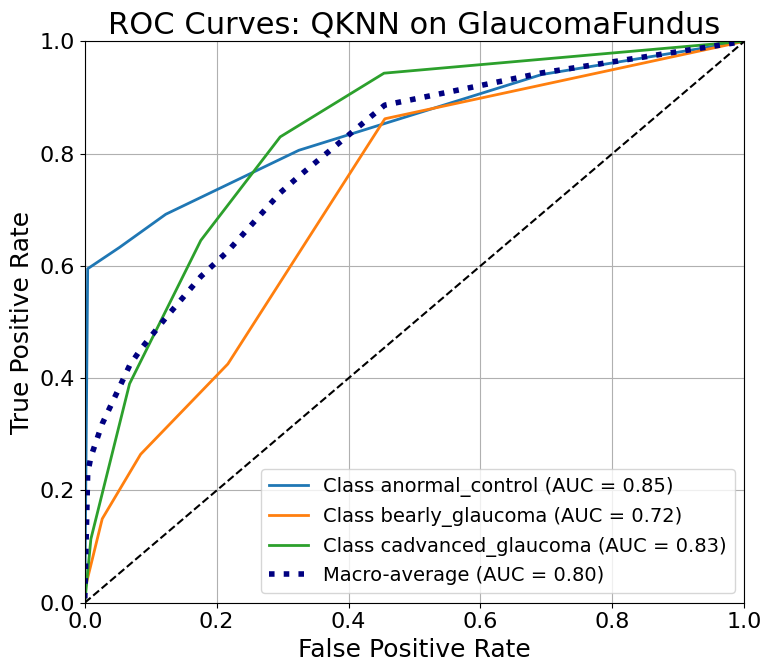

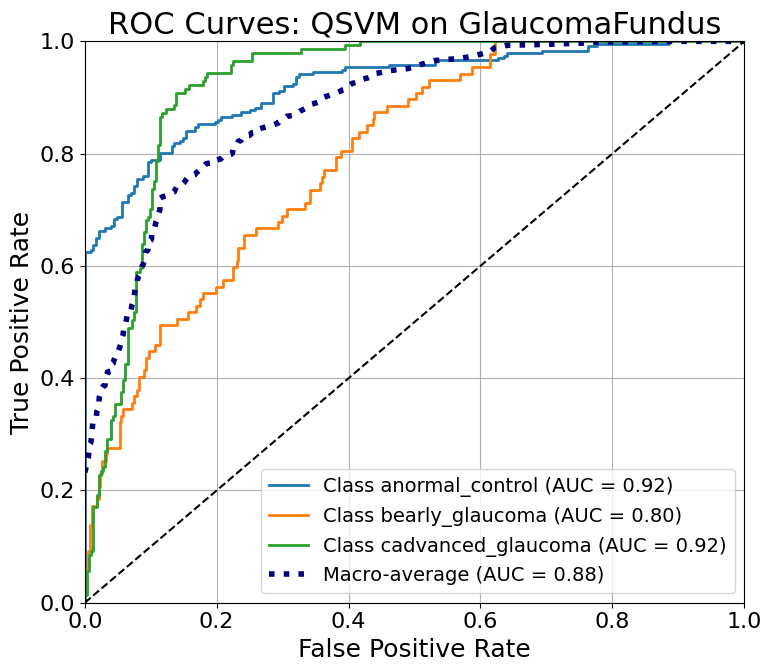

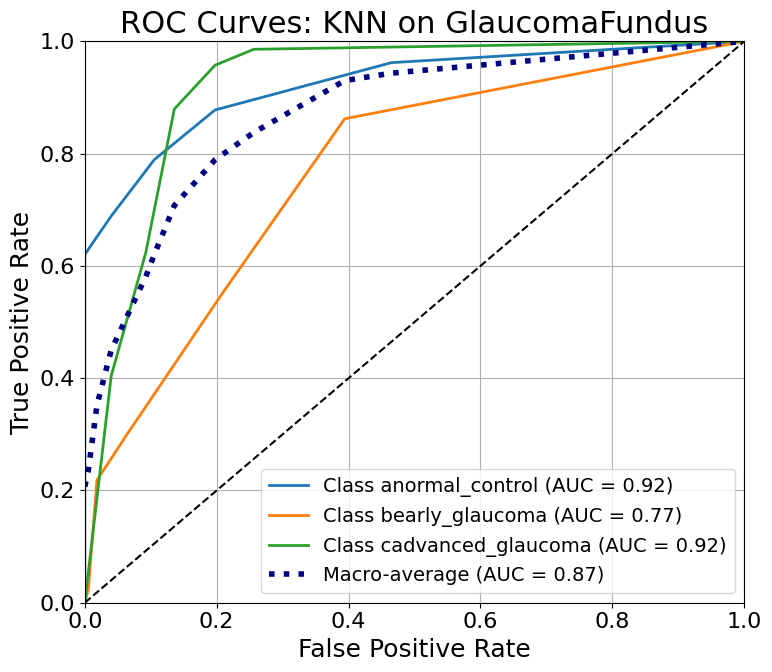

In [7]:
data_dir = data_dir
results = load_all_results(data_dir)
plot_roc_curves(results, data_dir)

Loaded: svm model for MESSIDOR dataset
Loaded: qknn model for MESSIDOR dataset
Loaded: qsvm model for MESSIDOR dataset
Loaded: knn model for MESSIDOR dataset
Loaded: qknn model for IDRID dataset
Loaded: knn model for IDRID dataset
Loaded: qsvm model for IDRID dataset
Loaded: svm model for IDRID dataset
Loaded: qsvm model for APTOS dataset
Loaded: qknn model for APTOS dataset
Loaded: knn model for APTOS dataset
Loaded: svm model for APTOS dataset
Loaded: qknn model for PAPILA dataset
Loaded: qsvm model for PAPILA dataset
Loaded: knn model for PAPILA dataset
Loaded: svm model for PAPILA dataset
Loaded: qsvm model for G1020 dataset
Loaded: svm model for G1020 dataset
Loaded: knn model for G1020 dataset
Loaded: qknn model for G1020 dataset
Loaded: svm model for GlaucomaFundus dataset
Loaded: qknn model for GlaucomaFundus dataset
Loaded: qsvm model for GlaucomaFundus dataset
Loaded: knn model for GlaucomaFundus dataset


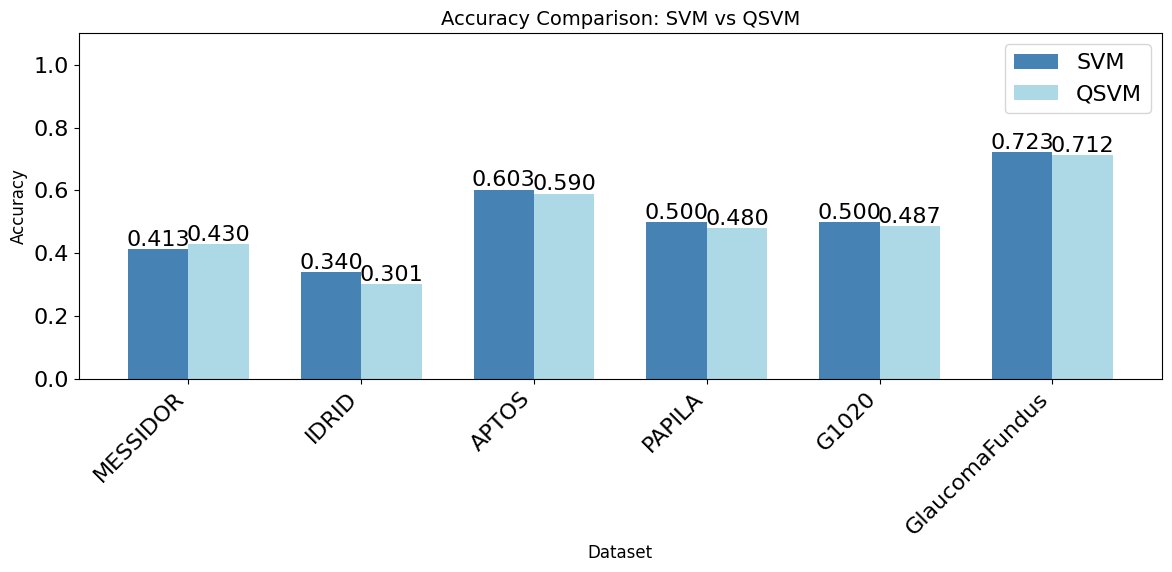

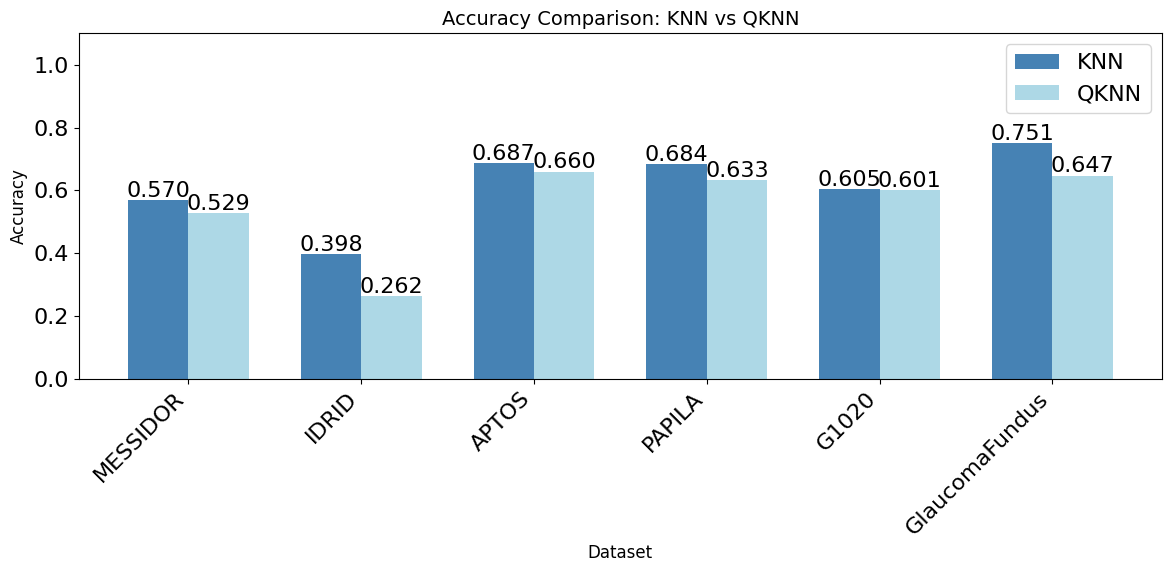

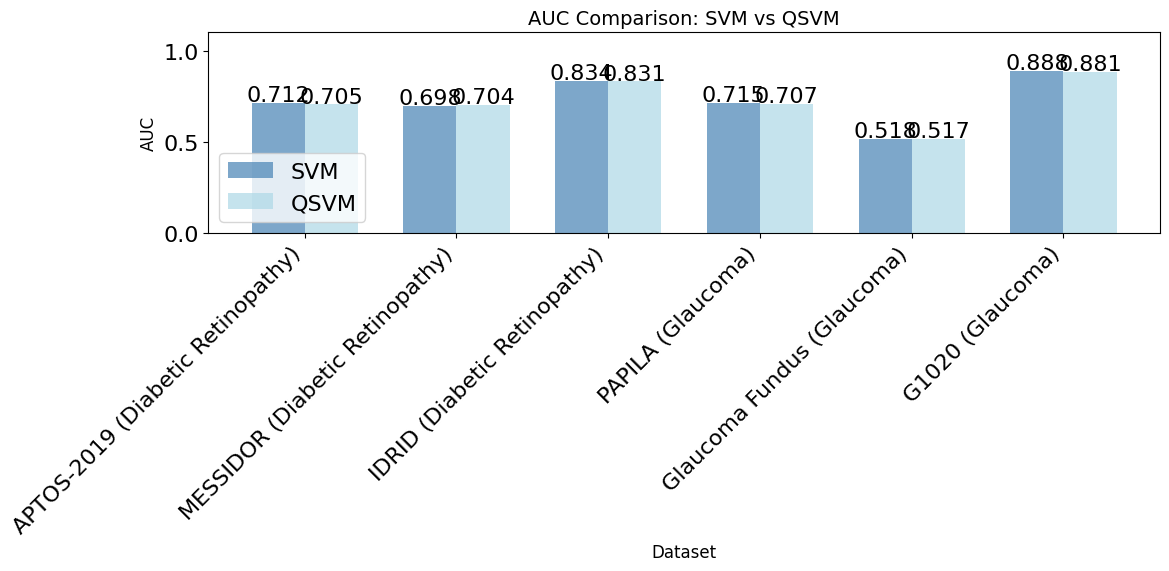

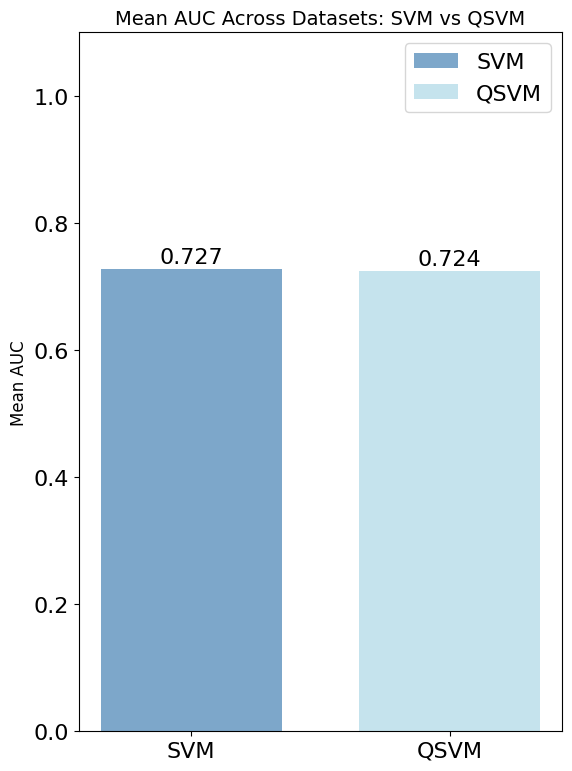

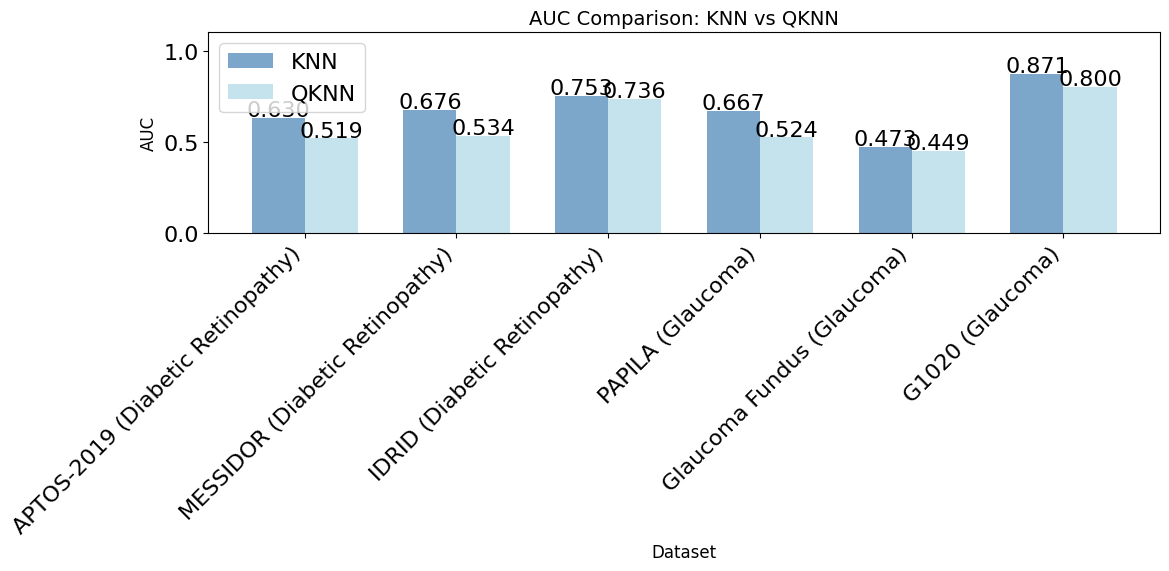

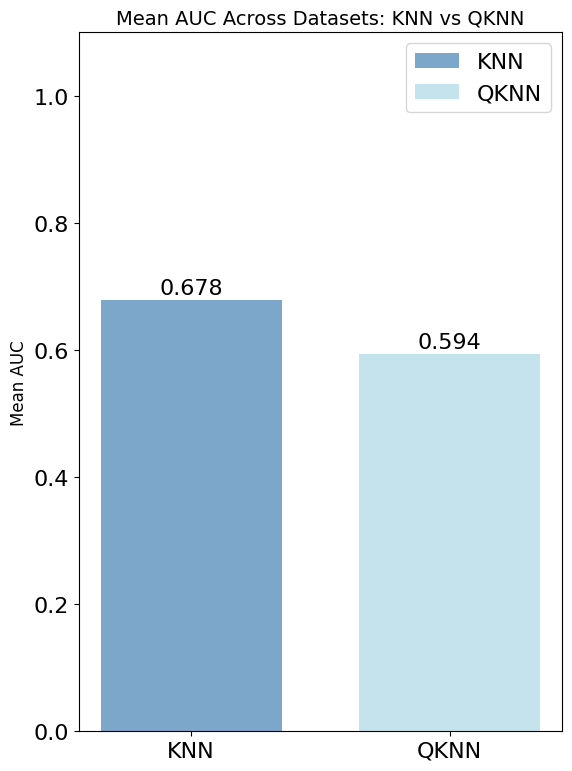

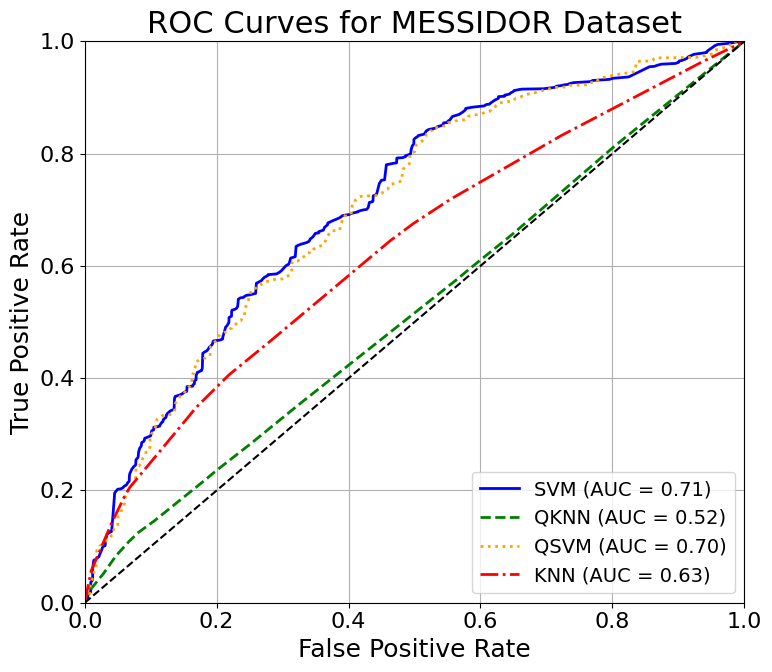

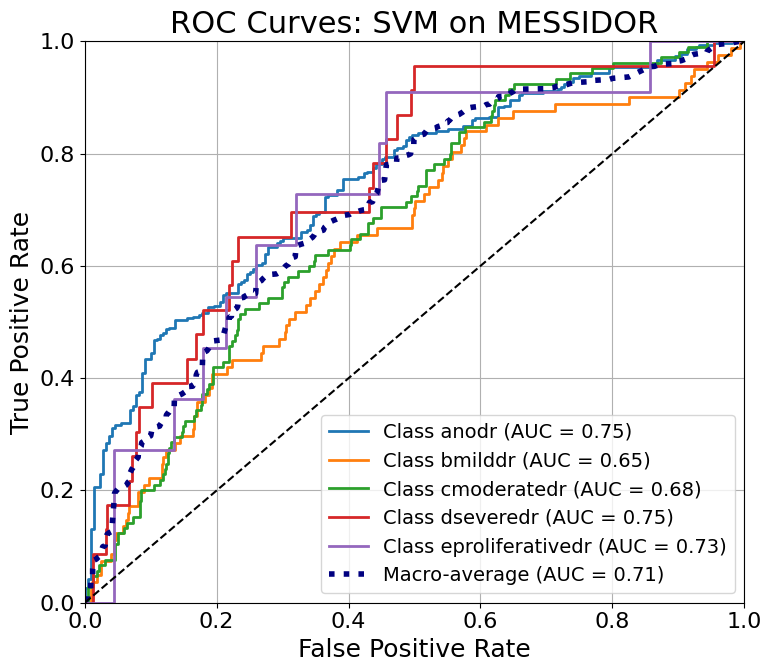

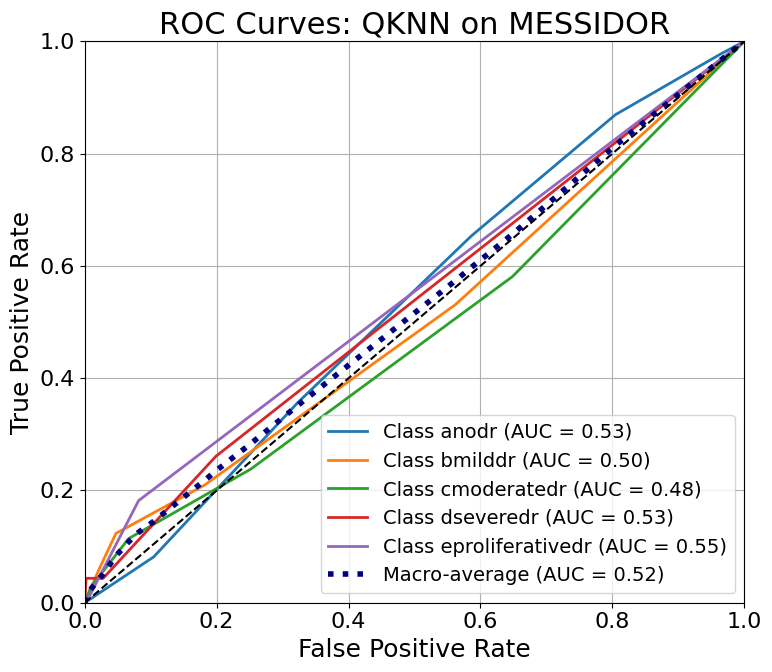

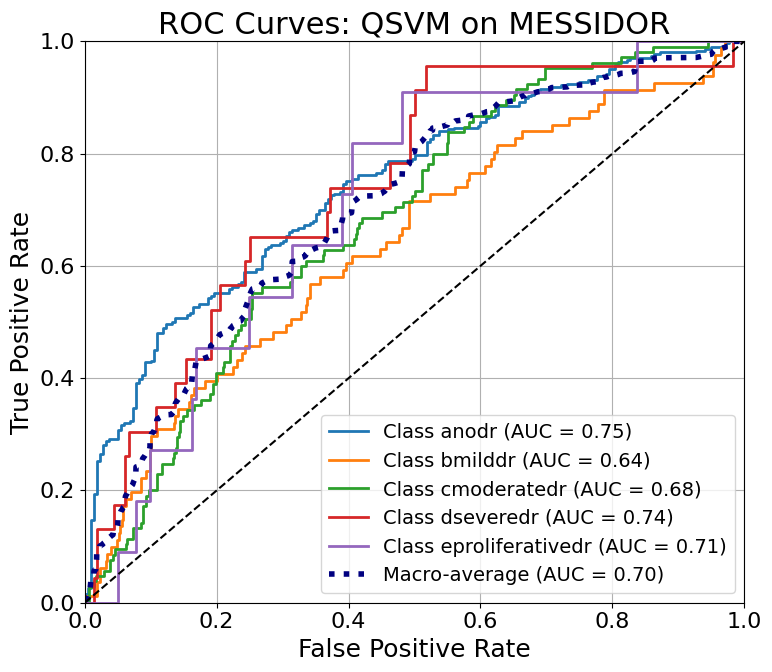

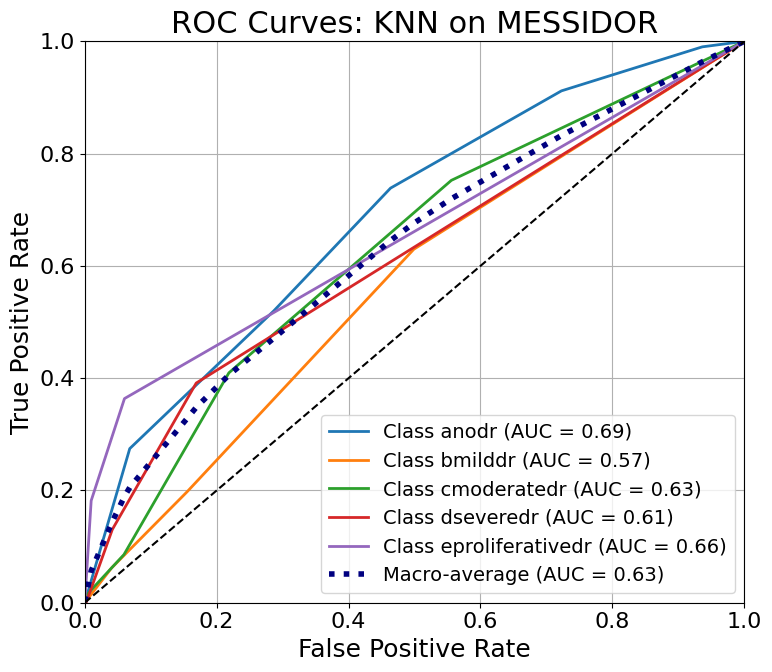

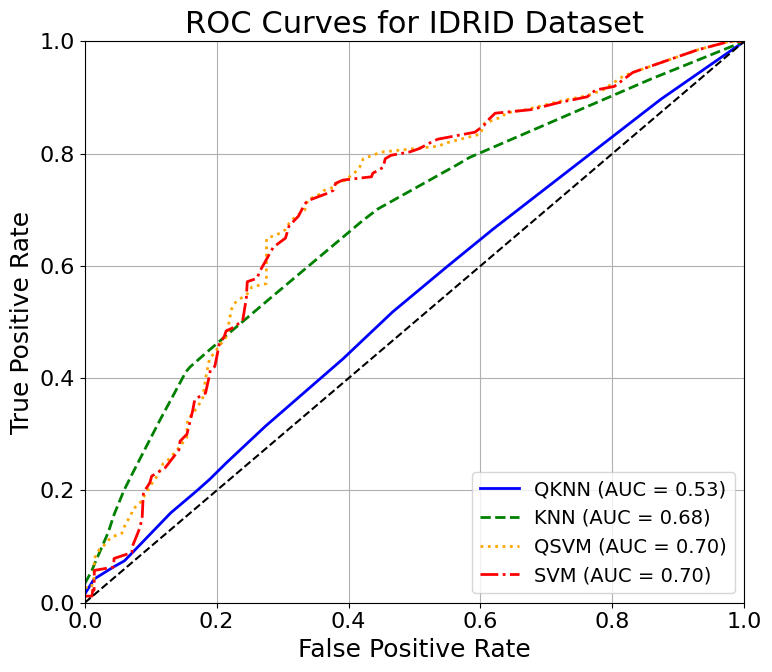

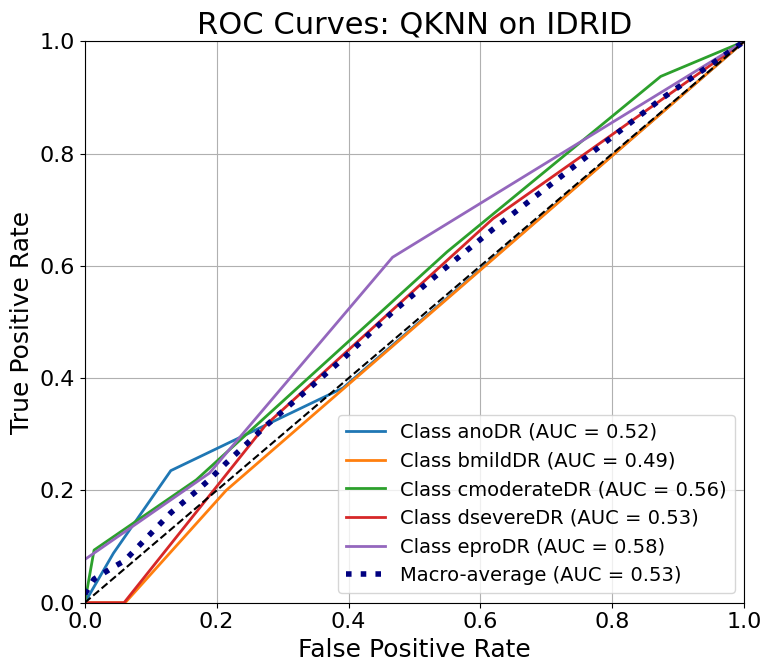

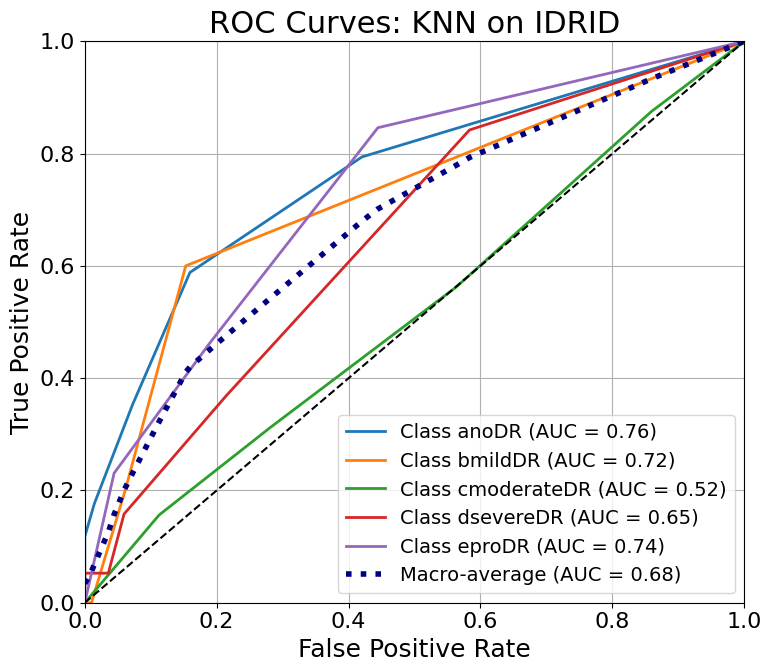

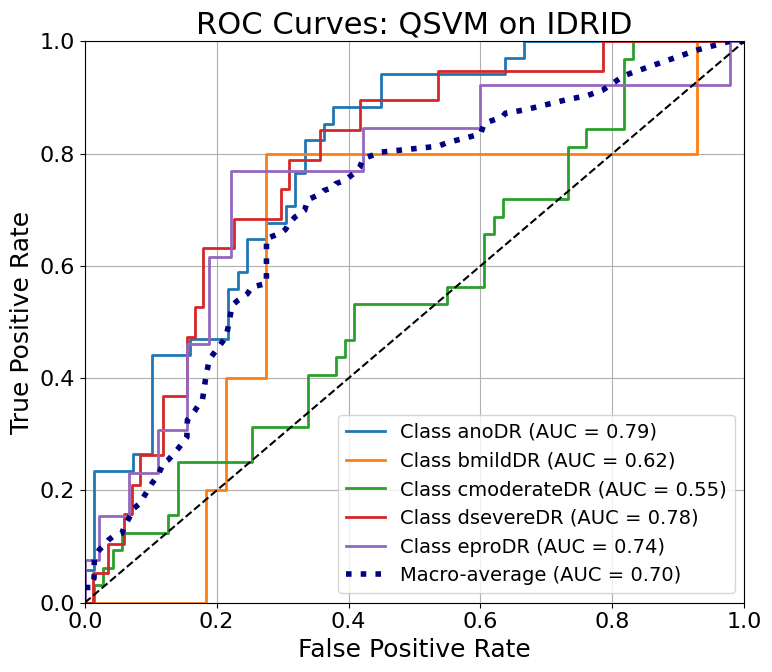

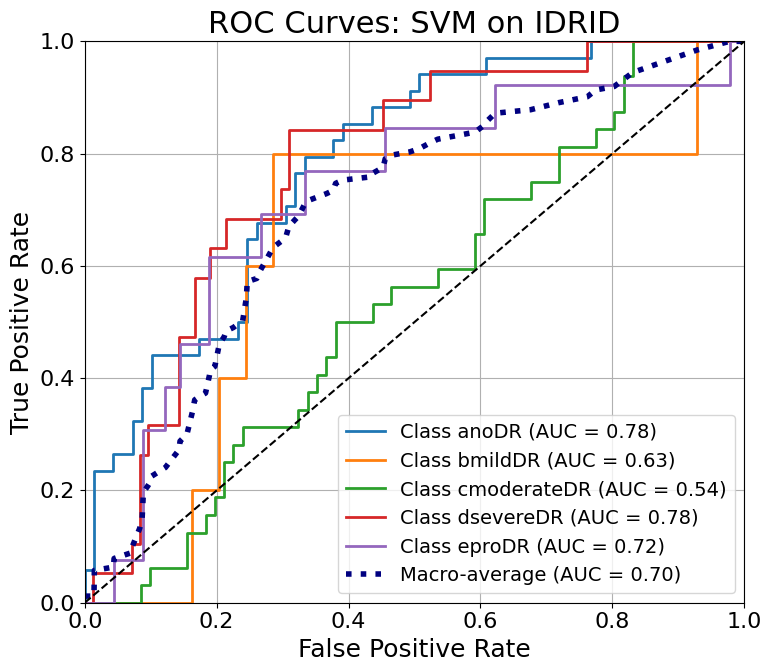

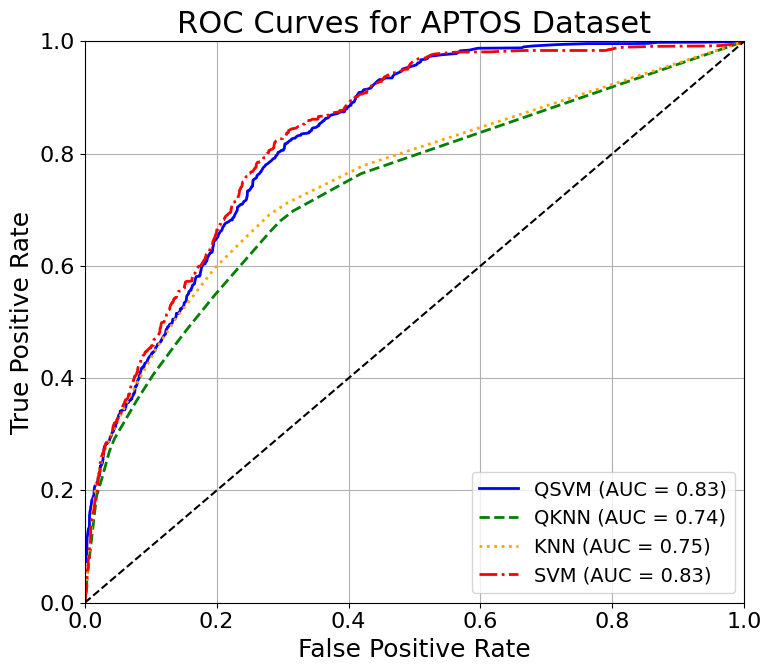

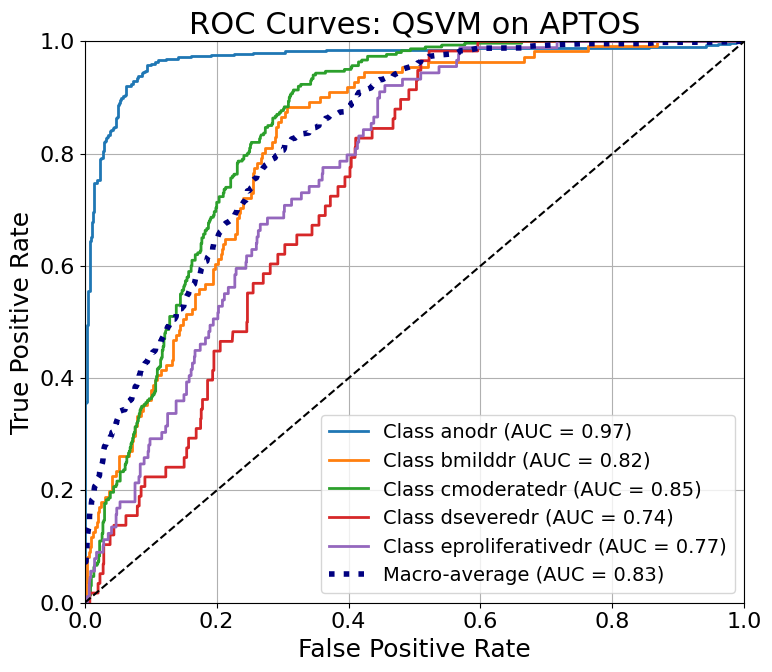

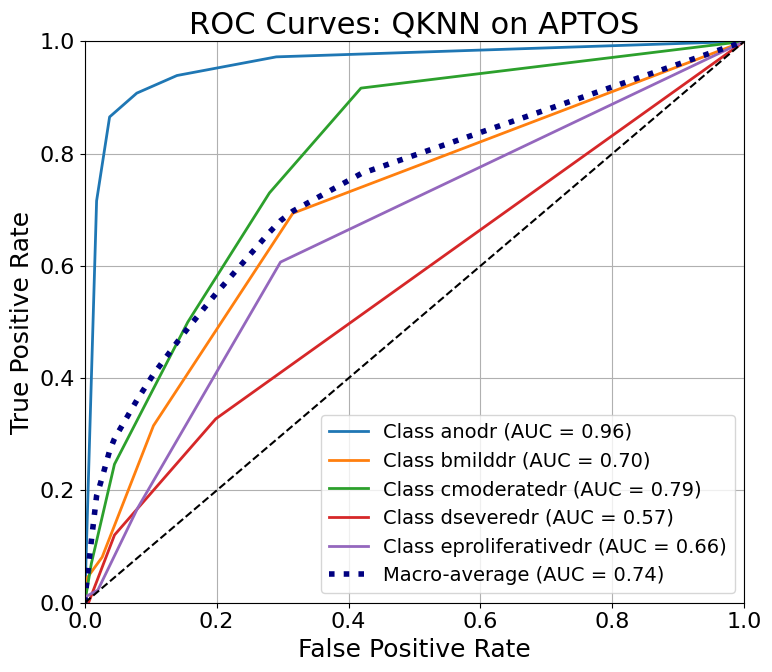

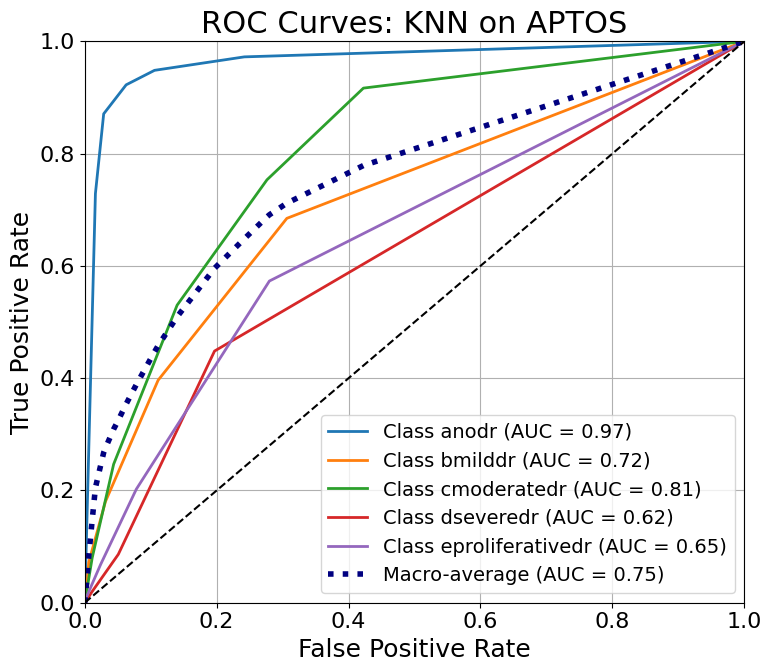

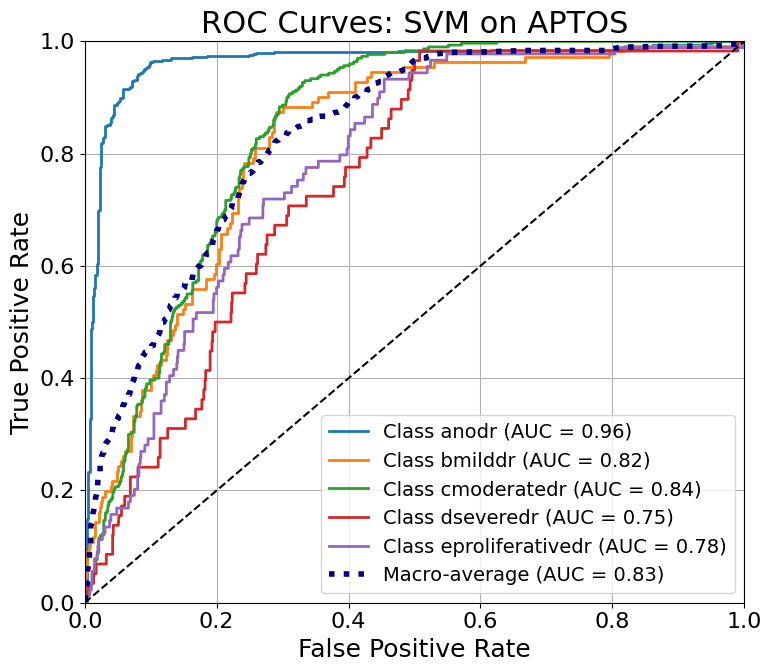

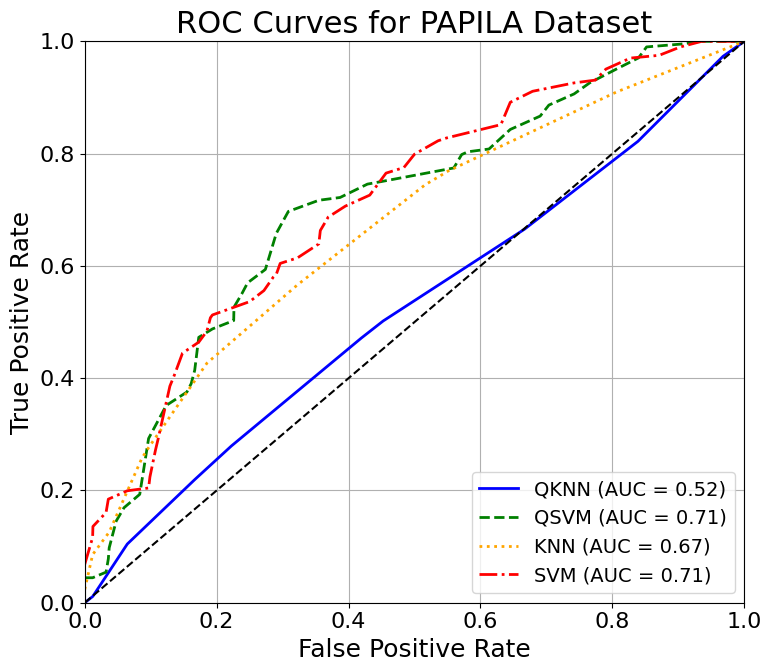

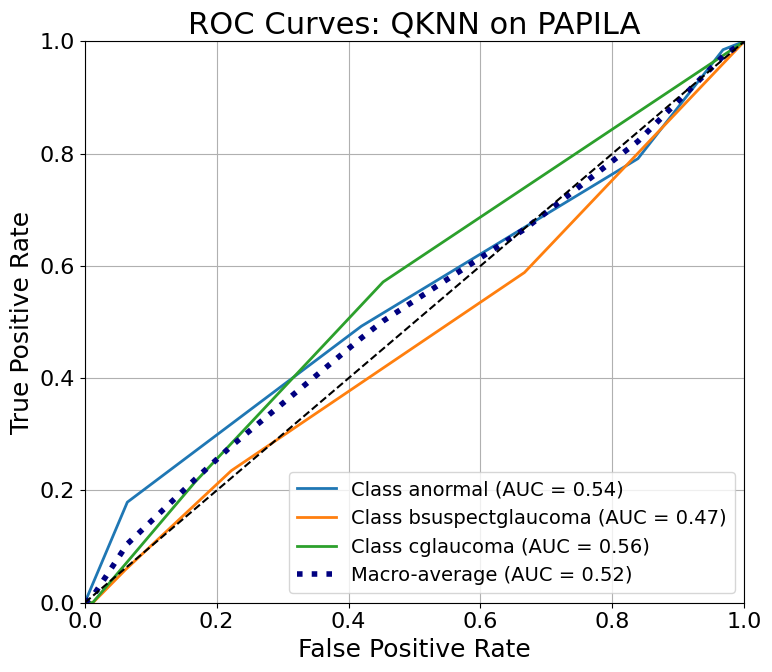

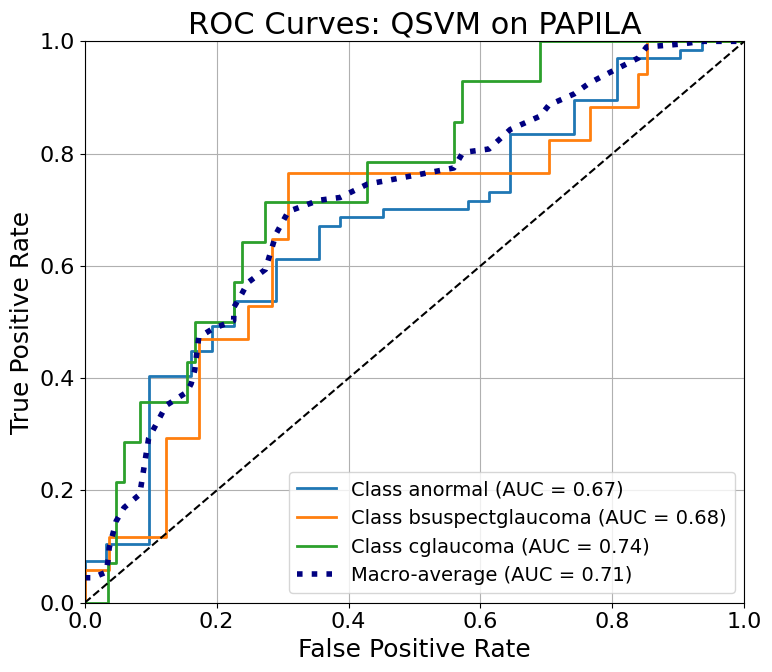

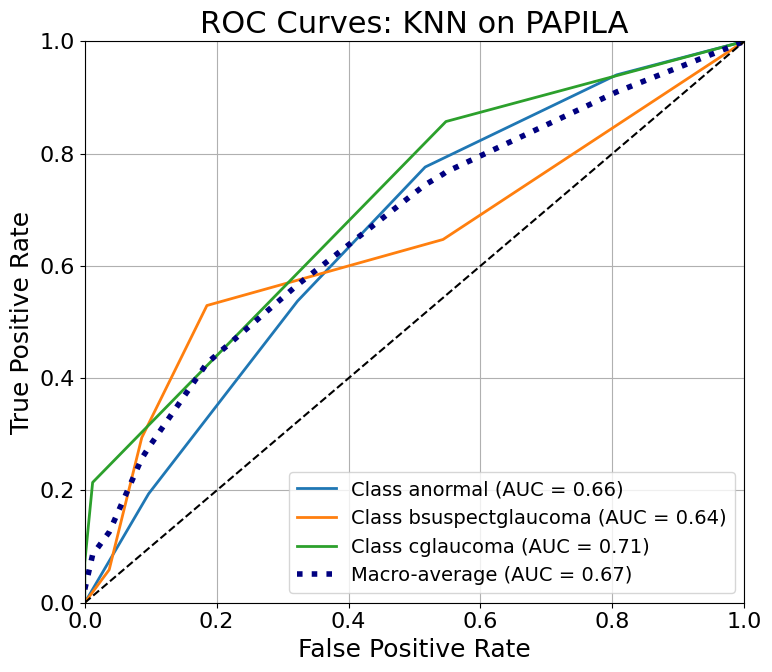

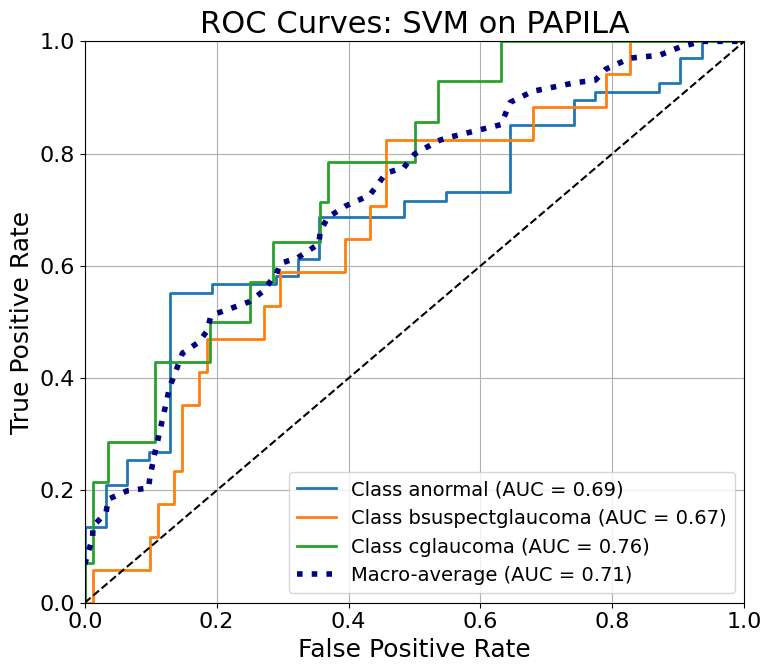

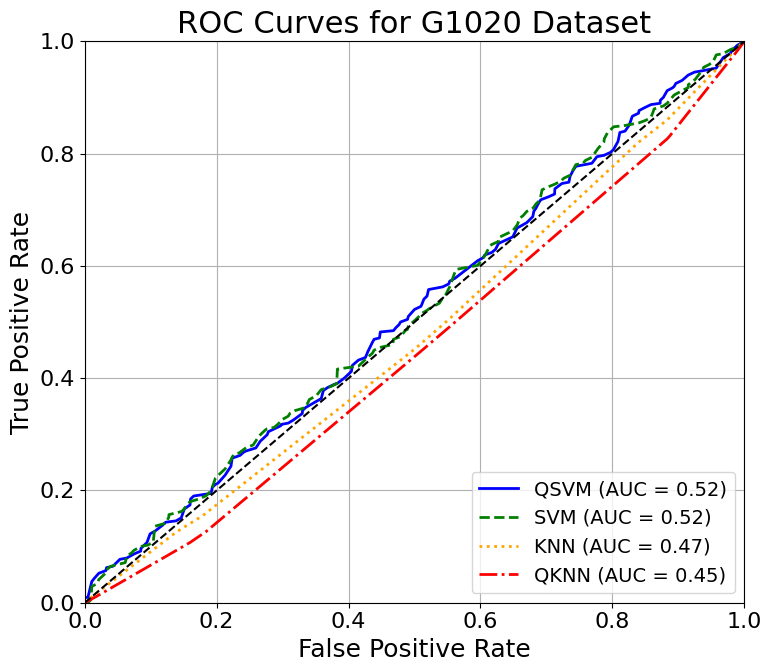

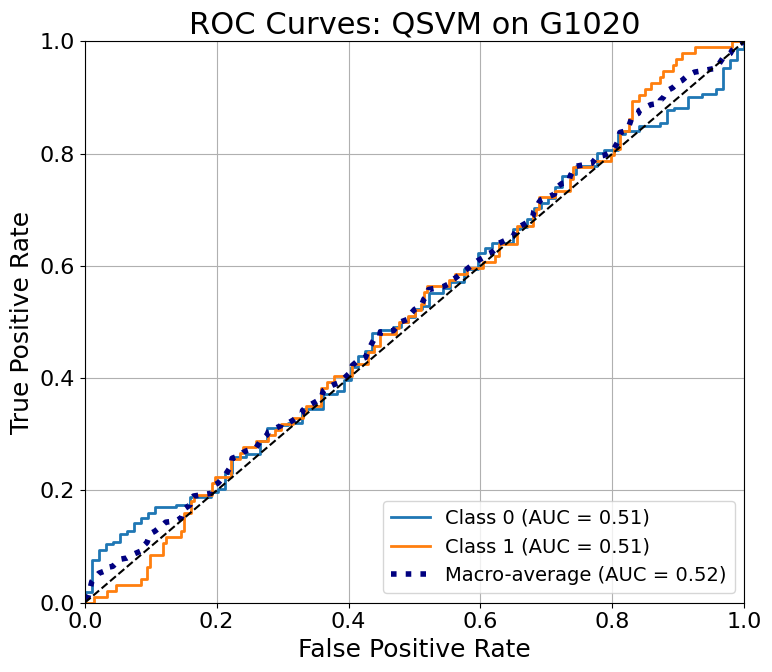

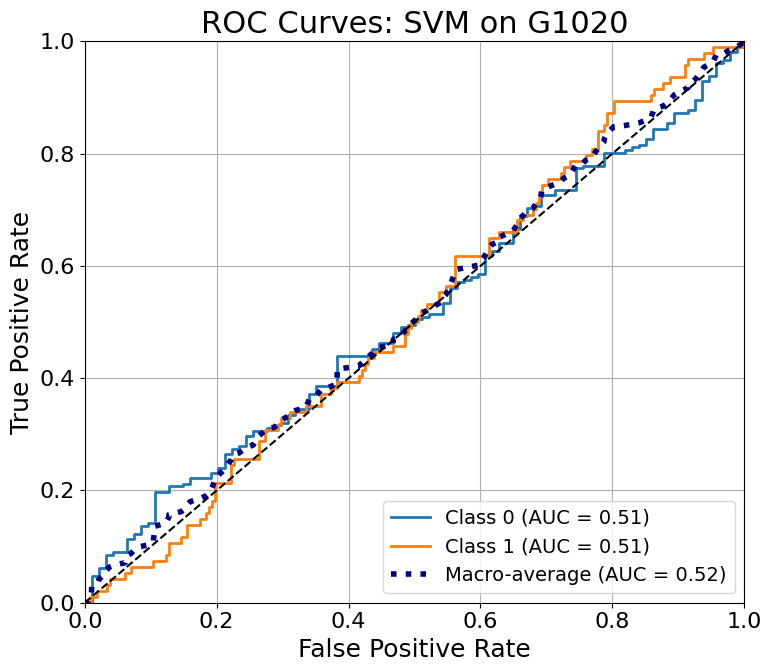

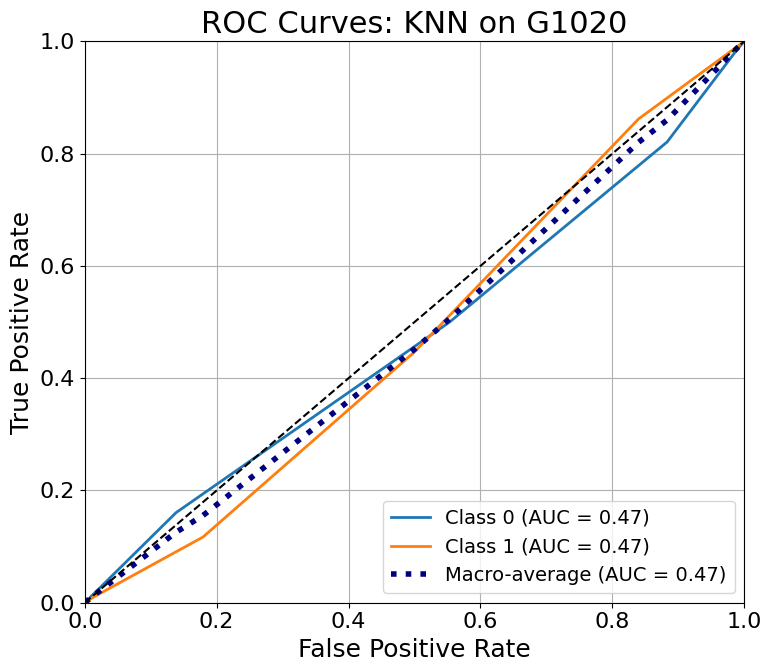

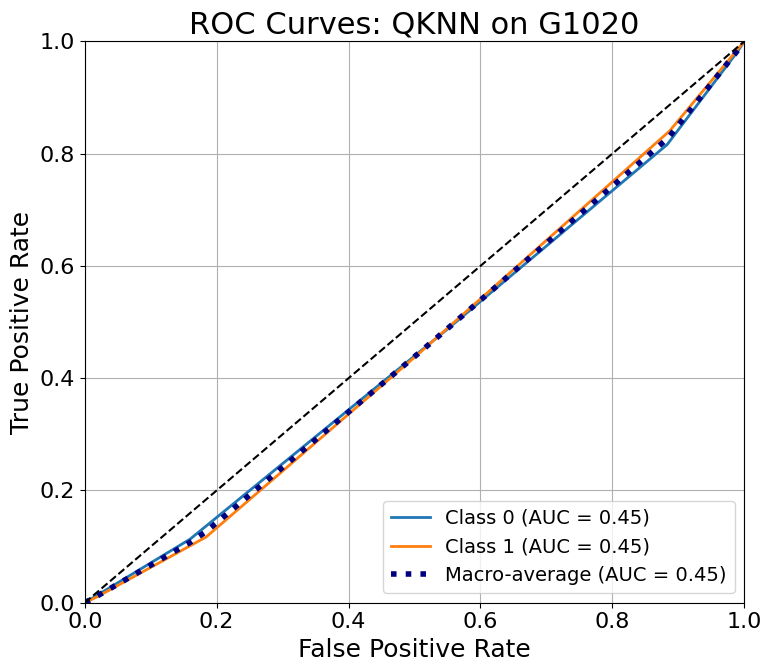

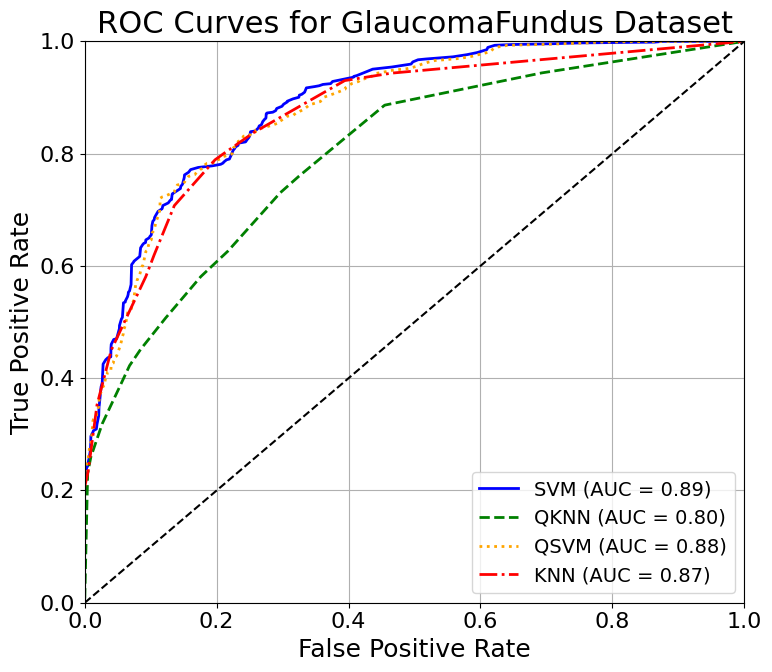

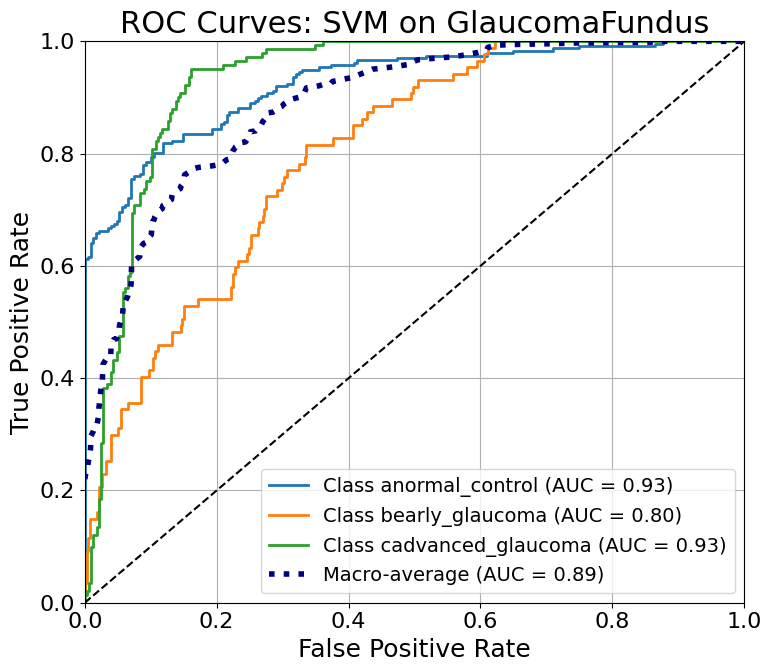

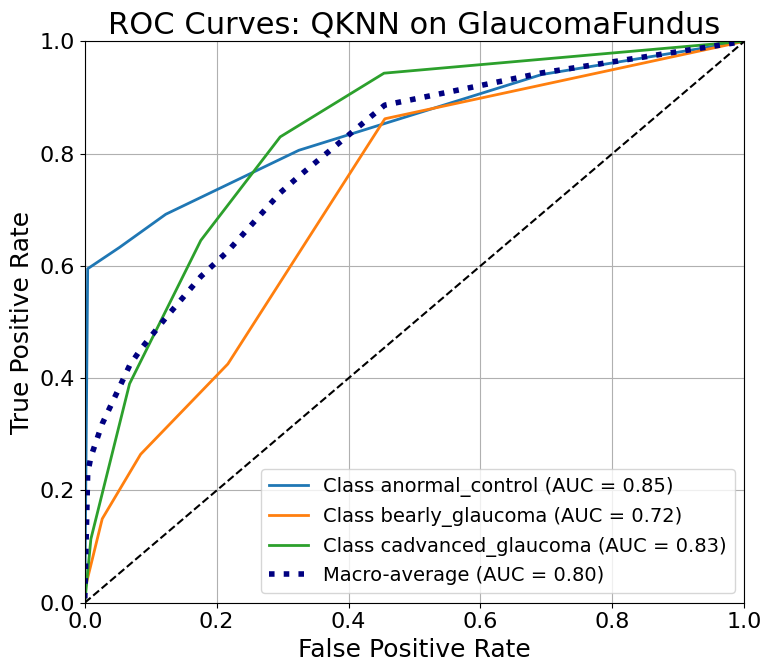

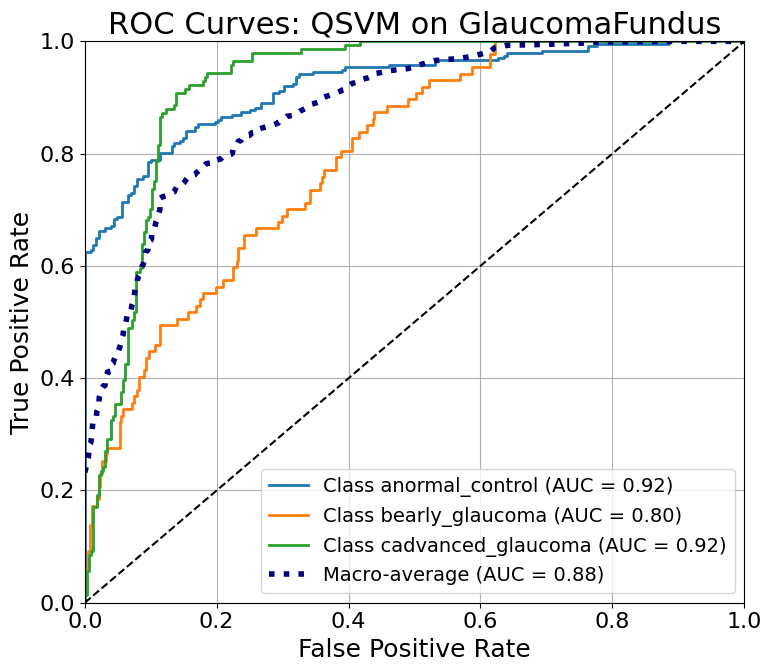

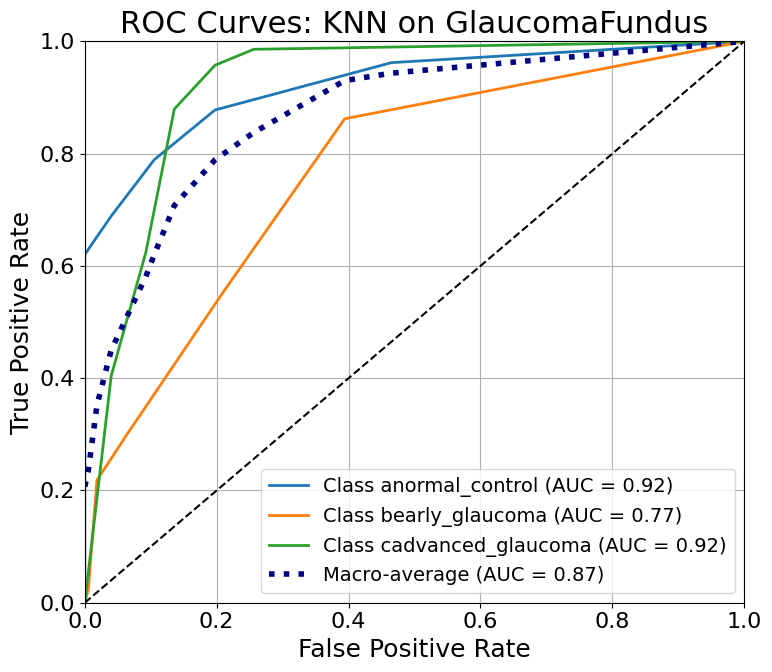


===== OVERALL PERFORMANCE METRICS =====
       Dataset Model  Accuracy  Precision   Recall  F1 Score Is Quantum
         APTOS   KNN  0.687273   0.656343 0.687273  0.667307         No
         APTOS  QKNN  0.660000   0.615120 0.660000  0.633702        Yes
         APTOS  QSVM  0.590000   0.683498 0.590000  0.581771        Yes
         APTOS   SVM  0.602727   0.684595 0.602727  0.599846         No
         G1020   KNN  0.604575   0.538023 0.604575  0.561328         No
         G1020  QKNN  0.601307   0.535770 0.601307  0.559138        Yes
         G1020  QSVM  0.486928   0.568749 0.486928  0.506389        Yes
         G1020   SVM  0.500000   0.579447 0.500000  0.519120         No
GlaucomaFundus   KNN  0.750538   0.738472 0.750538  0.741201         No
GlaucomaFundus  QKNN  0.647312   0.639928 0.647312  0.643197        Yes
GlaucomaFundus  QSVM  0.711828   0.780571 0.711828  0.724286        Yes
GlaucomaFundus   SVM  0.722581   0.781991 0.722581  0.732441         No
         IDRID   KNN  0

In [8]:
if __name__ == "__main__":
    data_dir = data_dir
    results = load_all_results(data_dir)
    compare_accuracy_bar_plots(results, data_dir)
    compare_auc_bar_plots(results, data_dir)
    plot_roc_curves(results, data_dir)
    create_performance_tables(results, data_dir)